# Notas

# Problem Description

Epidemic curves are a statistical chart to visualise the onset of a disease outbreak, and generally show the frequency of new cases compared to the date of disease onset. Also it can generally be broken down into three parts: a start (phase one), a middle (phase two) and and end (phase three).

![covid_pahes](img/curve_phases.jpg)

We intend to group each country's curves into three clusters based on their similarity as a way of labeling these curves based on their current phase.

After having our labeled data our goal is to build a model with this newly labeled data in order to classify in which phase other new curves may be at.

## Step 1 - Data manipulation and visualization

## Ler os Dados

In [1]:
# Defining Global Variables
DATA_FOLDER = 'data'
WORLD_DATA_FILE = 'world-data.csv'

# import the necessary dependencies
import pandas as pd

# creating custom date parser (mm/dd/yy)
from datetime import datetime
custom_date_parser = lambda x: datetime.strptime(x, '%m/%d/%y')

# re-read csv
covid_world_dataframe = pd.read_csv(f'{DATA_FOLDER}/{WORLD_DATA_FILE}', parse_dates=['Date'], date_parser=custom_date_parser)
covid_world_dataframe.head()

Province/State Country/Region      Lat     Long       Date  Confirmed  \
0            NaN    Afghanistan  33.0000  65.0000 2020-01-22          0   
1            NaN        Albania  41.1533  20.1683 2020-01-22          0   
2            NaN        Algeria  28.0339   1.6596 2020-01-22          0   
3            NaN        Andorra  42.5063   1.5218 2020-01-22          0   
4            NaN         Angola -11.2027  17.8739 2020-01-22          0   

   Deaths  Recovered  
0       0          0  
1       0          0  
2       0          0  
3       0          0  
4       0          0

## Tratamento dos Dados

### Correção de Problemas

### Problemas
 1. Alguns Paises não tem `Province/State`
 2. Os que têm `Province/State` também têm `Lat` e `Long` diferentes
 3. Os que têm `Province/State` também têm `Confirmed`, `Deaths` e `Recovered` para esse `Province/State`
 
### Solução
 1. Agrupar os dados por `Country/Region` e `Date`
 2. Fazer a média dentro do mesmo país
 3. Somar todos os casos das `Province/State` e colocar esse valor no país

In [2]:
# remover coluna 'Province/State'
covid_world_dataframe = covid_world_dataframe.drop(labels=['Province/State'], axis=1)
covid_world_dataframe.head()

Country/Region      Lat     Long       Date  Confirmed  Deaths  Recovered
0    Afghanistan  33.0000  65.0000 2020-01-22          0       0          0
1        Albania  41.1533  20.1683 2020-01-22          0       0          0
2        Algeria  28.0339   1.6596 2020-01-22          0       0          0
3        Andorra  42.5063   1.5218 2020-01-22          0       0          0
4         Angola -11.2027  17.8739 2020-01-22          0       0          0

In [3]:
# Calcular novas 'Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered'
aggregation_functions = {
    # Calculate the average latitude and longitude
    'Lat': 'mean',
    'Long': 'mean',
    # Calculate the sum of confirmed cases, deaths and recovered of the day
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum'
}
# group by country and date
covid_world_dataframe = covid_world_dataframe.groupby(['Date', 'Country/Region']).aggregate(aggregation_functions)
covid_world_dataframe.head()

Lat     Long  Confirmed  Deaths  Recovered
Date       Country/Region                                                
2020-01-22 Afghanistan     33.0000  65.0000          0       0          0
           Albania         41.1533  20.1683          0       0          0
           Algeria         28.0339   1.6596          0       0          0
           Andorra         42.5063   1.5218          0       0          0
           Angola         -11.2027  17.8739          0       0          0

Graças ao `groupby(['Date', 'Country/Region']` o indice das tabelas é o multi indice `[Date, Country/Region]`. Vamos voltar ao estado inicial:

```python
# Remover um indice específico, neste caso Country/Region
covid_world_dataframe = covid_world_dataframe.reset_index(level=['Country/Region'])
# Remover todos os indices
covid_world_dataframe = covid_world_dataframe.reset_index()
# ou
covid_world_dataframe.reset_index(inplace=True)
```

In [4]:
covid_world_dataframe = covid_world_dataframe.reset_index()
covid_world_dataframe.head()

Date Country/Region      Lat     Long  Confirmed  Deaths  Recovered
0 2020-01-22    Afghanistan  33.0000  65.0000          0       0          0
1 2020-01-22        Albania  41.1533  20.1683          0       0          0
2 2020-01-22        Algeria  28.0339   1.6596          0       0          0
3 2020-01-22        Andorra  42.5063   1.5218          0       0          0
4 2020-01-22         Angola -11.2027  17.8739          0       0          0

### Filtragem de Dados

Vamos filtrar apenas os Estados Unidos *(US)*, Reino Unido *(United Kingdom)*, China *(China)* e Portugal *(Portugal)*

In [5]:
# filter
countries = ['US', 'United Kingdom', 'China', 'Portugal']
covid_filtered_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'].isin(countries)]
covid_filtered_dataframe.head(8)

Date  Country/Region        Lat        Long  Confirmed  Deaths  \
36  2020-01-22           China  32.828385  111.649082        548      17   
136 2020-01-22        Portugal  39.399900   -8.224500          0       0   
174 2020-01-22              US  37.090200  -95.712900          1       0   
178 2020-01-22  United Kingdom  24.548173  -43.902245          0       0   
224 2020-01-23           China  32.828385  111.649082        643      18   
324 2020-01-23        Portugal  39.399900   -8.224500          0       0   
362 2020-01-23              US  37.090200  -95.712900          1       0   
366 2020-01-23  United Kingdom  24.548173  -43.902245          0       0   

     Recovered  
36          28  
136          0  
174          0  
178          0  
224         30  
324          0  
362          0  
366          0

### Plotting

Com os novos dados filtrados, vamos fazer um [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html), para conseguirmos comparar os casos confirmados, mortos e recuperados.

''

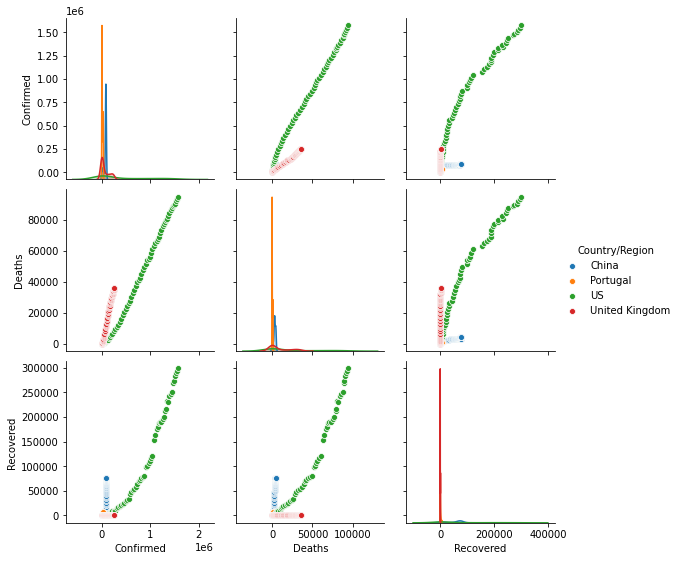

In [6]:
# plot
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb
sb.pairplot(covid_filtered_dataframe, hue='Country/Region', vars=['Confirmed', 'Deaths', 'Recovered'])
;

Vamos comparar os casos em Portugal ao longo do tempo

In [7]:
# create portgual dataframe
covid_portugal_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'] == 'Portugal']
covid_portugal_dataframe.head()

Date Country/Region      Lat    Long  Confirmed  Deaths  Recovered
136 2020-01-22       Portugal  39.3999 -8.2245          0       0          0
324 2020-01-23       Portugal  39.3999 -8.2245          0       0          0
512 2020-01-24       Portugal  39.3999 -8.2245          0       0          0
700 2020-01-25       Portugal  39.3999 -8.2245          0       0          0
888 2020-01-26       Portugal  39.3999 -8.2245          0       0          0

A forma mais facil de usar as datas como eixo horizontal é simplesmente torná-las como índice. O que até faz sentido uma vez que são unicas para cada país.

In [8]:
# set date as index and drop column
covid_portugal_dataframe.set_index('Date', inplace=True, drop=True)
covid_portugal_dataframe.head()

Country/Region      Lat    Long  Confirmed  Deaths  Recovered
Date                                                                    
2020-01-22       Portugal  39.3999 -8.2245          0       0          0
2020-01-23       Portugal  39.3999 -8.2245          0       0          0
2020-01-24       Portugal  39.3999 -8.2245          0       0          0
2020-01-25       Portugal  39.3999 -8.2245          0       0          0
2020-01-26       Portugal  39.3999 -8.2245          0       0          0

''

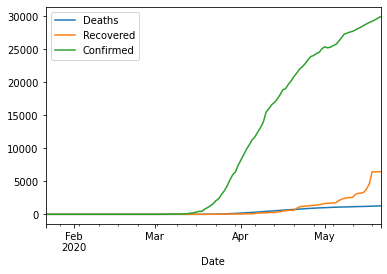

In [9]:
covid_portugal_dataframe[['Deaths', 'Recovered', 'Confirmed']].plot()
;

No entanto se quisermos usar explicitamente o **seaborn** (o que é obvio que queremos). Devemos usar o método `melt` e fazer reset ao indice.

In [10]:
covid_portugal_dataframe = covid_portugal_dataframe.reset_index()
covid_portugal_dataframe.head()

Date Country/Region      Lat    Long  Confirmed  Deaths  Recovered
0 2020-01-22       Portugal  39.3999 -8.2245          0       0          0
1 2020-01-23       Portugal  39.3999 -8.2245          0       0          0
2 2020-01-24       Portugal  39.3999 -8.2245          0       0          0
3 2020-01-25       Portugal  39.3999 -8.2245          0       0          0
4 2020-01-26       Portugal  39.3999 -8.2245          0       0          0

In [11]:
covid_portugal_dataframe_melt = pd.melt(covid_portugal_dataframe, ['Date', 'Country/Region', 'Lat', 'Long'], value_name='Count')
covid_portugal_dataframe_melt

Date Country/Region      Lat    Long   variable  Count
0   2020-01-22       Portugal  39.3999 -8.2245  Confirmed      0
1   2020-01-23       Portugal  39.3999 -8.2245  Confirmed      0
2   2020-01-24       Portugal  39.3999 -8.2245  Confirmed      0
3   2020-01-25       Portugal  39.3999 -8.2245  Confirmed      0
4   2020-01-26       Portugal  39.3999 -8.2245  Confirmed      0
..         ...            ...      ...     ...        ...    ...
358 2020-05-17       Portugal  39.3999 -8.2245  Recovered   4636
359 2020-05-18       Portugal  39.3999 -8.2245  Recovered   6430
360 2020-05-19       Portugal  39.3999 -8.2245  Recovered   6431
361 2020-05-20       Portugal  39.3999 -8.2245  Recovered   6452
362 2020-05-21       Portugal  39.3999 -8.2245  Recovered   6452

[363 rows x 6 columns]

''

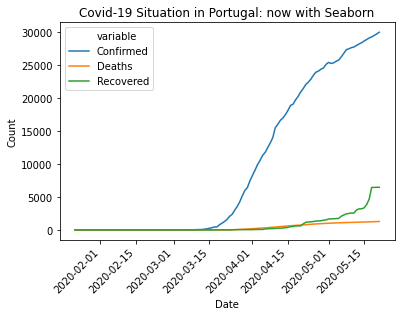

In [12]:
ax = sb.lineplot(x='Date', y='Count', hue='variable', data=covid_portugal_dataframe_melt)
ax.set_title('Covid-19 Situation in Portugal: now with Seaborn')
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
;

Caso queiremos ver os gráficos separamente (usando **seaborn**)::

''

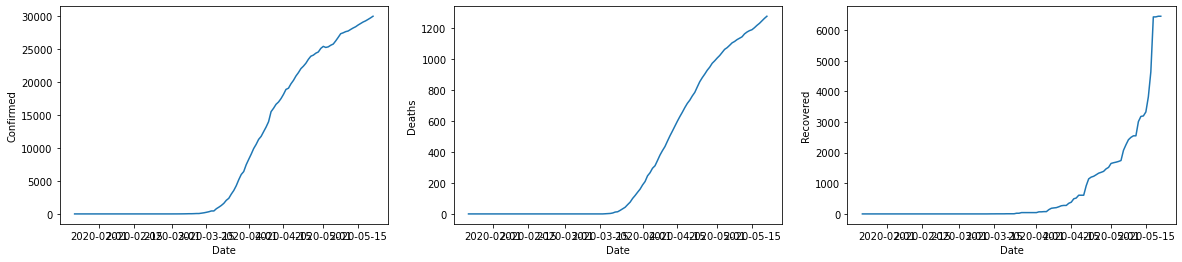

In [13]:
# criar area de plot
plt.figure(figsize=(20, 4))
# subplot de confirmed
plt.subplot(1, 3, 1)
sb.lineplot(x='Date', y='Confirmed', data=covid_portugal_dataframe)
# subplot de deaths
plt.subplot(1, 3, 2)
sb.lineplot(x='Date', y='Deaths', data=covid_portugal_dataframe)
# subplot de recovered
plt.subplot(1, 3, 3)
sb.lineplot(x='Date', y='Recovered', data=covid_portugal_dataframe)
# mostrar plot (nao necessario)
plt.draw()
;

Vamos comparar os 4 paises incialmente filtrados

Comparando casos confirmados entre os 4 paises

In [14]:
# create new dataset for chosen countries
confirmed_dataframe = covid_filtered_dataframe[['Date']].copy()
confirmed_dataframe.drop_duplicates(inplace=True)

def get_country_victims(country: str, victims: str):
    return covid_filtered_dataframe.loc[covid_filtered_dataframe['Country/Region'] == country , victims].tolist()

confirmed_dataframe['Portugal'] = get_country_victims('Portugal', 'Confirmed')
confirmed_dataframe['US'] = get_country_victims('US', 'Confirmed')
confirmed_dataframe['United Kingdom'] = get_country_victims('United Kingdom', 'Confirmed')
confirmed_dataframe['China'] = get_country_victims('China', 'Confirmed')
confirmed_dataframe

Date  Portugal       US  United Kingdom  China
36    2020-01-22         0        1               0    548
224   2020-01-23         0        1               0    643
412   2020-01-24         0        2               0    920
600   2020-01-25         0        2               0   1406
788   2020-01-26         0        5               0   2075
...          ...       ...      ...             ...    ...
21844 2020-05-17     29036  1486757          244995  84054
22032 2020-05-18     29209  1508308          247709  84063
22220 2020-05-19     29432  1528568          250138  84063
22408 2020-05-20     29660  1551853          249619  84063
22596 2020-05-21     29912  1577147          252246  84063

[121 rows x 5 columns]

''

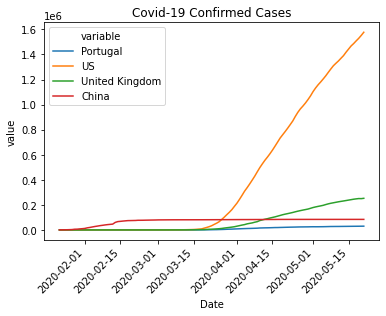

In [15]:
confirmed_dataframe_melt = pd.melt(confirmed_dataframe, ['Date'])
ax = sb.lineplot(x='Date', y='value', hue='variable', data=confirmed_dataframe_melt)
ax.set_title('Covid-19 Confirmed Cases')
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
;

Agora vamos ver a curva de casos confirmados destes 4 paises

In [16]:
# create portugal dataframe
# already done
# create US dataframe
covid_us_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'] == 'US']
# create UK dataframe
covid_uk_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'] == 'United Kingdom']
# create China dataframe
covid_china_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'] == 'China']

''

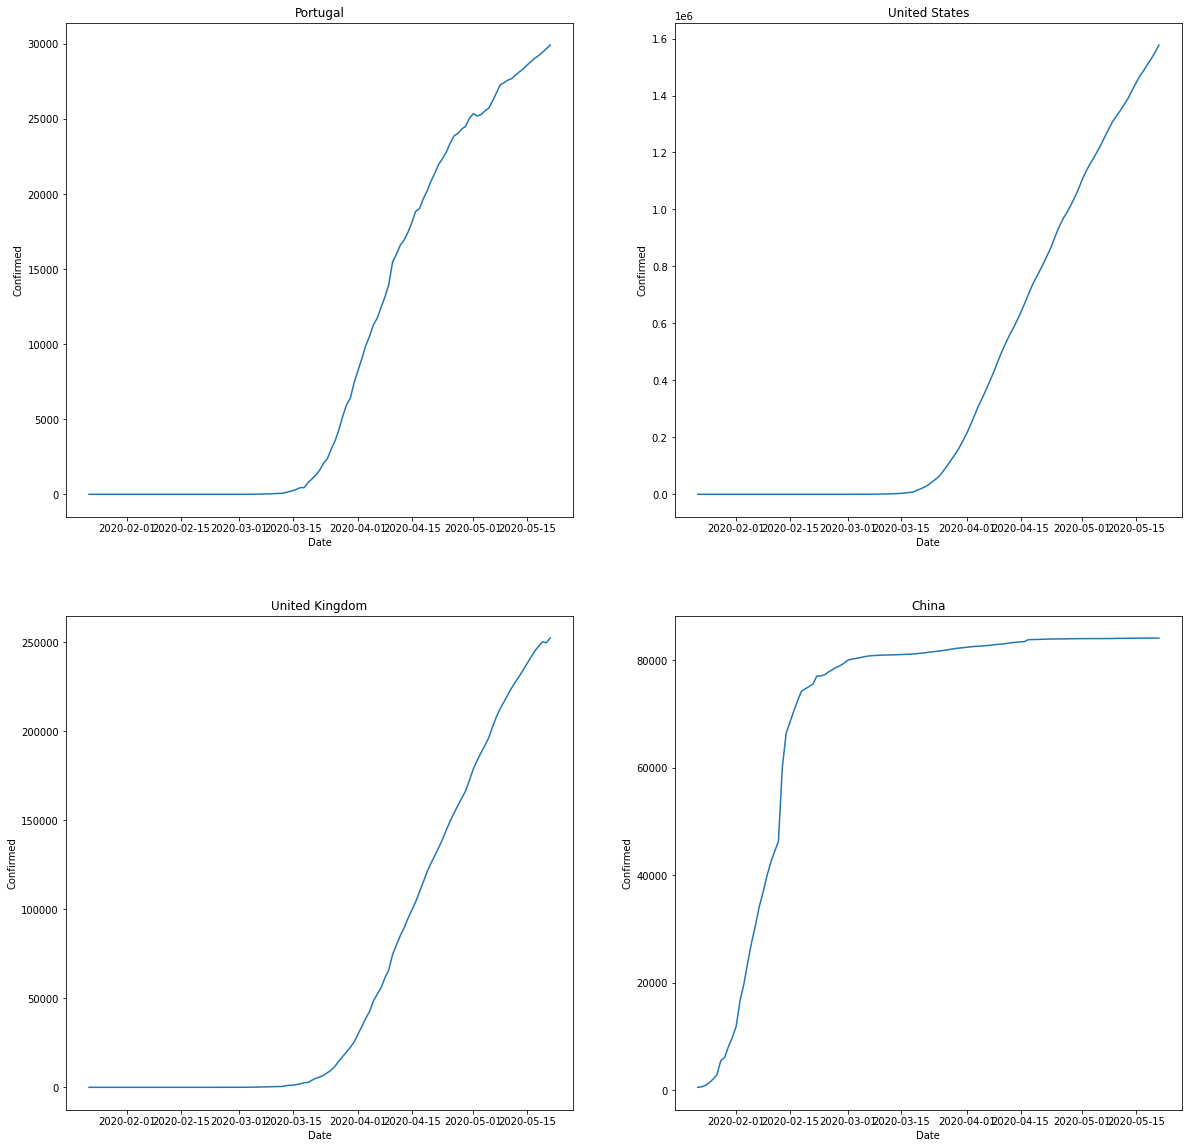

In [17]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
sb.lineplot(x='Date', y='Confirmed', data=covid_portugal_dataframe).set_title('Portugal')
plt.subplot(2, 2, 2)
sb.lineplot(x='Date', y='Confirmed', data=covid_us_dataframe).set_title('United States')
plt.subplot(2, 2, 3)
sb.lineplot(x='Date', y='Confirmed', data=covid_uk_dataframe).set_title('United Kingdom')
plt.subplot(2, 2, 4)
sb.lineplot(x='Date', y='Confirmed', data=covid_china_dataframe).set_title('China')
;

## Part 2 - Clustering

**SOURCE:** https://towardsdatascience.com/classify-growth-patterns-for-covid-19-data-41af4c7adc55

**GITHUB:** https://github.com/Perishleaf/data-visualisation-scripts/blob/master/coronavirus_country_PCoA/COVID-19_analysis.ipynb

Nevertheless, visual differentiation of these many curves is rather difficult. It is better to classify these curves into clusters, in which similar curves are classified as the same group. Here, I combined Principle Co-ordinates Analysis (PCoA) with k-mean clustering to plot similarities of countries/regions incremental patterns on a 2-D dimension and classify them into groups. In a nutshell, nearby circles (i.e countries/regions) in 2-D ordination should have similar growth patterns, circles which are far apart from each other have few patterns in common.

Let's make contry rows into columns: https://stackoverflow.com/questions/17298313/python-pandas-convert-rows-as-column-headers

In [18]:
# we dont need to remove unused columns, pivot_table already does that
'''
# remove lat, long, deaths and recovered
new_dataframe = covid_world_dataframe.drop(labels=['Lat', 'Long', 'Deaths', 'Recovered'], axis=1)
new_dataframe
'''
new_dataframe = covid_world_dataframe.pivot_table('Confirmed', ['Date'], 'Country/Region')
new_dataframe

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
Date                                                             
2020-01-22                0        0        0        0       0   
2020-01-23                0        0        0        0       0   
2020-01-24                0        0        0        0       0   
2020-01-25                0        0        0        0       0   
2020-01-26                0        0        0        0       0   
...                     ...      ...      ...      ...     ...   
2020-05-17             6664      946     7019      761      48   
2020-05-18             7072      948     7201      761      50   
2020-05-19             7653      949     7377      761      52   
2020-05-20             8145      964     7542      762      52   
2020-05-21             8676      969     7728      762      58   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
Date                                                                          
2020-01-22                        0          0        0          0        0   
2020-01-23                        0          0        0          0        0   
2020-01-24                        0          0        0          0        0   
2020-01-25                        0          0        0          0        0   
2020-01-26                        0          0        0          4        0   
...                             ...        ...      ...        ...      ...   
2020-05-17                       25       8068     4472       7054    16242   
2020-05-18                       25       8371     4823       7068    16269   
2020-05-19                       25       8809     5041       7072    16321   
2020-05-20                       25       9283     5271       7081    16353   
2020-05-21                       25       9931     5606       7095    16404   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
Date            ...                                                            
2020-01-22      ...               0        0           0          0        0   
2020-01-23      ...               0        0           0          0        2   
2020-01-24      ...               0        0           0          0        2   
2020-01-25      ...               0        0           0          0        2   
2020-01-26      ...               0        0           0          0        2   
...             ...             ...      ...         ...        ...      ...   
2020-05-17      ...          244995      734        2753        541      320   
2020-05-18      ...          247709      737        2791        618      324   
2020-05-19      ...          250138      738        2855        749      324   
2020-05-20      ...          249619      746        2939        824      324   
2020-05-21      ...          252246      749        2964        882      324   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
Date                                                                         
2020-01-22                       0               0      0       0         0  
2020-01-23                       0               0      0       0         0  
2020-01-24                       0               0      0       0         0  
2020-01-25                       0               0      0       0         0  
2020-01-26                       0               0      0       0         0  
...                            ...             ...    ...     ...       ...  
2020-05-17                     381               6    128     753        44  
2020-05-18                     388               6    130     761        46  
2020-05-19                     391               6    167     772        46  
2020-05-20                     398               6    184     832        48  
2020-05-21                     423               6    197     866        51  

[121 rows x 188 columns]

Now we can clearly see, we have **121 days** and **188 countries.**

### Problem
 - Data is cumulative
 
### Solution
 - Let's make it differential (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html)
 

In [19]:
# store first row
first_row = new_dataframe.iloc[0]
new_dataframe = new_dataframe.diff()
new_dataframe.iloc[0] = first_row
new_dataframe

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
Date                                                             
2020-01-22              0.0      0.0      0.0      0.0     0.0   
2020-01-23              0.0      0.0      0.0      0.0     0.0   
2020-01-24              0.0      0.0      0.0      0.0     0.0   
2020-01-25              0.0      0.0      0.0      0.0     0.0   
2020-01-26              0.0      0.0      0.0      0.0     0.0   
...                     ...      ...      ...      ...     ...   
2020-05-17            262.0     13.0    198.0      0.0     0.0   
2020-05-18            408.0      2.0    182.0      0.0     2.0   
2020-05-19            581.0      1.0    176.0      0.0     2.0   
2020-05-20            492.0     15.0    165.0      1.0     0.0   
2020-05-21            531.0      5.0    186.0      0.0     6.0   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
Date                                                                          
2020-01-22                      0.0        0.0      0.0        0.0      0.0   
2020-01-23                      0.0        0.0      0.0        0.0      0.0   
2020-01-24                      0.0        0.0      0.0        0.0      0.0   
2020-01-25                      0.0        0.0      0.0        0.0      0.0   
2020-01-26                      0.0        0.0      0.0        4.0      0.0   
...                             ...        ...      ...        ...      ...   
2020-05-17                      0.0      263.0    189.0       10.0     41.0   
2020-05-18                      0.0      303.0    351.0       14.0     27.0   
2020-05-19                      0.0      438.0    218.0        4.0     52.0   
2020-05-20                      0.0      474.0    230.0        9.0     32.0   
2020-05-21                      0.0      648.0    335.0       14.0     51.0   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
Date            ...                                                            
2020-01-22      ...             0.0      0.0         0.0        0.0      0.0   
2020-01-23      ...             0.0      0.0         0.0        0.0      2.0   
2020-01-24      ...             0.0      0.0         0.0        0.0      0.0   
2020-01-25      ...             0.0      0.0         0.0        0.0      0.0   
2020-01-26      ...             0.0      0.0         0.0        0.0      0.0   
...             ...             ...      ...         ...        ...      ...   
2020-05-17      ...          3534.0      1.0        15.0       37.0      2.0   
2020-05-18      ...          2714.0      3.0        38.0       77.0      4.0   
2020-05-19      ...          2429.0      1.0        64.0      131.0      0.0   
2020-05-20      ...          -519.0      8.0        84.0       75.0      0.0   
2020-05-21      ...          2627.0      3.0        25.0       58.0      0.0   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
Date                                                                         
2020-01-22                     0.0             0.0    0.0     0.0       0.0  
2020-01-23                     0.0             0.0    0.0     0.0       0.0  
2020-01-24                     0.0             0.0    0.0     0.0       0.0  
2020-01-25                     0.0             0.0    0.0     0.0       0.0  
2020-01-26                     0.0             0.0    0.0     0.0       0.0  
...                            ...             ...    ...     ...       ...  
2020-05-17                     5.0             0.0    6.0    74.0       2.0  
2020-05-18                     7.0             0.0    2.0     8.0       2.0  
2020-05-19                     3.0             0.0   37.0    11.0       0.0  
2020-05-20                     7.0             0.0   17.0    60.0       2.0  
2020-05-21                    25.0             0.0   13.0    34.0       3.0  

[121 rows x 188 columns]

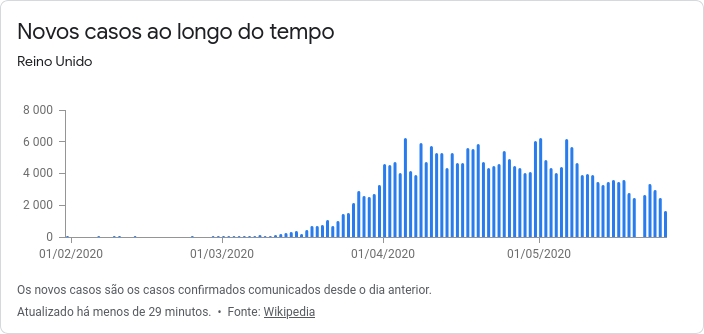

### Problema
Vemos que alguns paises têm falta de dados em alguns dias, como é o caso do **United Kingdom** no dia **2020-05-20**. Isto porque é impossível em dados comulativos haver diferenças negativas entre dias.

### Solução
Substituir esses valores negativos não pela média, uma vez que a média acaba por destabilizar a evolução diária, mas sim pela média do dia anterior e dia seguinte. Para isso usa-se o `interpolate()`. https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html#interpolation

In [20]:
import numpy as np

new_dataframe[new_dataframe < 0] = np.nan
new_dataframe = new_dataframe.interpolate()
new_dataframe

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
Date                                                             
2020-01-22              0.0      0.0      0.0      0.0     0.0   
2020-01-23              0.0      0.0      0.0      0.0     0.0   
2020-01-24              0.0      0.0      0.0      0.0     0.0   
2020-01-25              0.0      0.0      0.0      0.0     0.0   
2020-01-26              0.0      0.0      0.0      0.0     0.0   
...                     ...      ...      ...      ...     ...   
2020-05-17            262.0     13.0    198.0      0.0     0.0   
2020-05-18            408.0      2.0    182.0      0.0     2.0   
2020-05-19            581.0      1.0    176.0      0.0     2.0   
2020-05-20            492.0     15.0    165.0      1.0     0.0   
2020-05-21            531.0      5.0    186.0      0.0     6.0   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
Date                                                                          
2020-01-22                      0.0        0.0      0.0        0.0      0.0   
2020-01-23                      0.0        0.0      0.0        0.0      0.0   
2020-01-24                      0.0        0.0      0.0        0.0      0.0   
2020-01-25                      0.0        0.0      0.0        0.0      0.0   
2020-01-26                      0.0        0.0      0.0        4.0      0.0   
...                             ...        ...      ...        ...      ...   
2020-05-17                      0.0      263.0    189.0       10.0     41.0   
2020-05-18                      0.0      303.0    351.0       14.0     27.0   
2020-05-19                      0.0      438.0    218.0        4.0     52.0   
2020-05-20                      0.0      474.0    230.0        9.0     32.0   
2020-05-21                      0.0      648.0    335.0       14.0     51.0   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
Date            ...                                                            
2020-01-22      ...             0.0      0.0         0.0        0.0      0.0   
2020-01-23      ...             0.0      0.0         0.0        0.0      2.0   
2020-01-24      ...             0.0      0.0         0.0        0.0      0.0   
2020-01-25      ...             0.0      0.0         0.0        0.0      0.0   
2020-01-26      ...             0.0      0.0         0.0        0.0      0.0   
...             ...             ...      ...         ...        ...      ...   
2020-05-17      ...          3534.0      1.0        15.0       37.0      2.0   
2020-05-18      ...          2714.0      3.0        38.0       77.0      4.0   
2020-05-19      ...          2429.0      1.0        64.0      131.0      0.0   
2020-05-20      ...          2528.0      8.0        84.0       75.0      0.0   
2020-05-21      ...          2627.0      3.0        25.0       58.0      0.0   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
Date                                                                         
2020-01-22                     0.0             0.0    0.0     0.0       0.0  
2020-01-23                     0.0             0.0    0.0     0.0       0.0  
2020-01-24                     0.0             0.0    0.0     0.0       0.0  
2020-01-25                     0.0             0.0    0.0     0.0       0.0  
2020-01-26                     0.0             0.0    0.0     0.0       0.0  
...                            ...             ...    ...     ...       ...  
2020-05-17                     5.0             0.0    6.0    74.0       2.0  
2020-05-18                     7.0             0.0    2.0     8.0       2.0  
2020-05-19                     3.0             0.0   37.0    11.0       0.0  
2020-05-20                     7.0             0.0   17.0    60.0       2.0  
2020-05-21                    25.0             0.0   13.0    34.0       3.0  

[121 rows x 188 columns]

**PCoA** and **[K-mean clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)** for growing pattern

In [195]:
# Only include coutries with more than 5000 confirmed cases
new_data_thousand = new_dataframe[[i for i in new_dataframe.columns if new_dataframe[i].sum() > 2000]]
new_data_thousand

Country/Region  Afghanistan  Algeria  Argentina  Armenia  Australia  Austria  \
Date                                                                           
2020-01-22              0.0      0.0        0.0      0.0        0.0      0.0   
2020-01-23              0.0      0.0        0.0      0.0        0.0      0.0   
2020-01-24              0.0      0.0        0.0      0.0        0.0      0.0   
2020-01-25              0.0      0.0        0.0      0.0        0.0      0.0   
2020-01-26              0.0      0.0        0.0      0.0        4.0      0.0   
...                     ...      ...        ...      ...        ...      ...   
2020-05-17            262.0    198.0      263.0    189.0       10.0     41.0   
2020-05-18            408.0    182.0      303.0    351.0       14.0     27.0   
2020-05-19            581.0    176.0      438.0    218.0        4.0     52.0   
2020-05-20            492.0    165.0      474.0    230.0        9.0     32.0   
2020-05-21            531.0    186.0      648.0    335.0       14.0     51.0   

Country/Region  Azerbaijan  Bahrain  Bangladesh  Belarus  ...  Sweden  \
Date                                                      ...           
2020-01-22             0.0      0.0         0.0      0.0  ...     0.0   
2020-01-23             0.0      0.0         0.0      0.0  ...     0.0   
2020-01-24             0.0      0.0         0.0      0.0  ...     0.0   
2020-01-25             0.0      0.0         0.0      0.0  ...     0.0   
2020-01-26             0.0      0.0         0.0      0.0  ...     0.0   
...                    ...      ...         ...      ...  ...     ...   
2020-05-17           136.0    209.0      1273.0    969.0  ...   466.0   
2020-05-18           113.0    228.0      1602.0    922.0  ...   234.0   
2020-05-19           131.0    348.0      1251.0    936.0  ...   422.0   
2020-05-20           113.0    356.0      1617.0    918.0  ...   724.0   
2020-05-21           118.0    286.0      1773.0    945.0  ...   649.0   

Country/Region  Switzerland  Tajikistan  Thailand  Turkey       US  Ukraine  \
Date                                                                          
2020-01-22              0.0         0.0       2.0     0.0      1.0      0.0   
2020-01-23              0.0         0.0       1.0     0.0      0.0      0.0   
2020-01-24              0.0         0.0       2.0     0.0      1.0      0.0   
2020-01-25              0.0         0.0       2.0     0.0      0.0      0.0   
2020-01-26              0.0         0.0       1.0     0.0      3.0      0.0   
...                     ...         ...       ...     ...      ...      ...   
2020-05-17             15.0       202.0       3.0  1368.0  18937.0    433.0   
2020-05-18             10.0       205.0       3.0  1158.0  21551.0    325.0   
2020-05-19             21.0       207.0       2.0  1022.0  20260.0    260.0   
2020-05-20             40.0       204.0       1.0   972.0  23285.0    354.0   
2020-05-21             36.0       210.0       3.0   961.0  25294.0    476.0   

Country/Region  United Arab Emirates  United Kingdom  Uzbekistan  
Date                                                              
2020-01-22                       0.0             0.0         0.0  
2020-01-23                       0.0             0.0         0.0  
2020-01-24                       0.0             0.0         0.0  
2020-01-25                       0.0             0.0         0.0  
2020-01-26                       0.0             0.0         0.0  
...                              ...             ...         ...  
2020-05-17                     731.0          3534.0        15.0  
2020-05-18                     832.0          2714.0        38.0  
2020-05-19                     873.0          2429.0        64.0  
2020-05-20                     941.0          2528.0        84.0  
2020-05-21                     894.0          2627.0        25.0  

[121 rows x 83 columns]

Since we only interested in the patterns, the effect of data size should be minimised, for example, daily incremental numbers in mainland China are orders higher than that of many other countries. We do not want these differences to be included in our analysis. The solution here is to first transform data as square root and normalise them as numbers between zero and one. In doing so, we only catch up the variance in the patterns when calculating similarities between different countries/regions.

https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

In [196]:
# Data transformation to reduce the effect of data scale on pattern identification
# Square root transformation
new_data_thousand = new_data_thousand**0.5
new_data_thousand

Country/Region  Afghanistan    Algeria  Argentina    Armenia  Australia  \
Date                                                                      
2020-01-22         0.000000   0.000000   0.000000   0.000000   0.000000   
2020-01-23         0.000000   0.000000   0.000000   0.000000   0.000000   
2020-01-24         0.000000   0.000000   0.000000   0.000000   0.000000   
2020-01-25         0.000000   0.000000   0.000000   0.000000   0.000000   
2020-01-26         0.000000   0.000000   0.000000   0.000000   2.000000   
...                     ...        ...        ...        ...        ...   
2020-05-17        16.186414  14.071247  16.217275  13.747727   3.162278   
2020-05-18        20.199010  13.490738  17.406895  18.734994   3.741657   
2020-05-19        24.103942  13.266499  20.928450  14.764823   2.000000   
2020-05-20        22.181073  12.845233  21.771541  15.165751   3.000000   
2020-05-21        23.043437  13.638182  25.455844  18.303005   3.741657   

Country/Region   Austria  Azerbaijan    Bahrain  Bangladesh    Belarus  ...  \
Date                                                                    ...   
2020-01-22      0.000000    0.000000   0.000000    0.000000   0.000000  ...   
2020-01-23      0.000000    0.000000   0.000000    0.000000   0.000000  ...   
2020-01-24      0.000000    0.000000   0.000000    0.000000   0.000000  ...   
2020-01-25      0.000000    0.000000   0.000000    0.000000   0.000000  ...   
2020-01-26      0.000000    0.000000   0.000000    0.000000   0.000000  ...   
...                  ...         ...        ...         ...        ...  ...   
2020-05-17      6.403124   11.661904  14.456832   35.679126  31.128765  ...   
2020-05-18      5.196152   10.630146  15.099669   40.024992  30.364453  ...   
2020-05-19      7.211103   11.445523  18.654758   35.369478  30.594117  ...   
2020-05-20      5.656854   10.630146  18.867962   40.211939  30.298515  ...   
2020-05-21      7.141428   10.862780  16.911535   42.107007  30.740852  ...   

Country/Region     Sweden  Switzerland  Tajikistan  Thailand     Turkey  \
Date                                                                      
2020-01-22       0.000000     0.000000    0.000000  1.414214   0.000000   
2020-01-23       0.000000     0.000000    0.000000  1.000000   0.000000   
2020-01-24       0.000000     0.000000    0.000000  1.414214   0.000000   
2020-01-25       0.000000     0.000000    0.000000  1.414214   0.000000   
2020-01-26       0.000000     0.000000    0.000000  1.000000   0.000000   
...                   ...          ...         ...       ...        ...   
2020-05-17      21.587033     3.872983   14.212670  1.732051  36.986484   
2020-05-18      15.297059     3.162278   14.317821  1.732051  34.029399   
2020-05-19      20.542639     4.582576   14.387495  1.414214  31.968735   
2020-05-20      26.907248     6.324555   14.282857  1.000000  31.176915   
2020-05-21      25.475478     6.000000   14.491377  1.732051  31.000000   

Country/Region          US    Ukraine  United Arab Emirates  United Kingdom  \
Date                                                                          
2020-01-22        1.000000   0.000000              0.000000        0.000000   
2020-01-23        0.000000   0.000000              0.000000        0.000000   
2020-01-24        1.000000   0.000000              0.000000        0.000000   
2020-01-25        0.000000   0.000000              0.000000        0.000000   
2020-01-26        1.732051   0.000000              0.000000        0.000000   
...                    ...        ...                   ...             ...   
2020-05-17      137.611773  20.808652             27.037012       59.447456   
2020-05-18      146.802589  18.027756             28.844410       52.096065   
2020-05-19      142.337627  16.124515             29.546573       49.284886   
2020-05-20      152.594233  18.814888             30.675723       50.279220   
2020-05-21      159.040875  21.817424             29.899833       51.254

In [197]:
# Normalisation column-wise
from sklearn import preprocessing

x = new_data_thousand.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
new_data_thousand_norm = pd.DataFrame(x_scaled)
new_data_thousand_norm.columns = new_data_thousand.columns
new_data_thousand_norm

Country/Region  Afghanistan   Algeria  Argentina   Armenia  Australia  \
0                  0.000000  0.000000   0.000000  0.000000   0.000000   
1                  0.000000  0.000000   0.000000  0.000000   0.000000   
2                  0.000000  0.000000   0.000000  0.000000   0.000000   
3                  0.000000  0.000000   0.000000  0.000000   0.000000   
4                  0.000000  0.000000   0.000000  0.000000   0.089712   
..                      ...       ...        ...       ...        ...   
116                0.671526  0.997484   0.637075  0.733799   0.141848   
117                0.837996  0.956333   0.683807  1.000000   0.167836   
118                1.000000  0.940437   0.822147  0.788088   0.089712   
119                0.920226  0.910574   0.855267  0.809488   0.134568   
120                0.956003  0.966785   1.000000  0.976942   0.167836   

Country/Region   Austria  Azerbaijan   Bahrain  Bangladesh   Belarus  ...  \
0               0.000000    0.000000  0.000000    0.000000  0.000000  ...   
1               0.000000    0.000000  0.000000    0.000000  0.000000  ...   
2               0.000000    0.000000  0.000000    0.000000  0.000000  ...   
3               0.000000    0.000000  0.000000    0.000000  0.000000  ...   
4               0.000000    0.000000  0.000000    0.000000  0.000000  ...   
..                   ...         ...       ...         ...       ...  ...   
116             0.176173    0.927771  0.736788    0.847344  0.807790  ...   
117             0.142965    0.845689  0.769550    0.950554  0.787956  ...   
118             0.198404    0.910557  0.950735    0.839990  0.793916  ...   
119             0.155641    0.845689  0.961600    0.954994  0.786245  ...   
120             0.196487    0.864196  0.861892    1.000000  0.797724  ...   

Country/Region    Sweden  Switzerland  Tajikistan  Thailand    Turkey  \
0               0.000000     0.000000    0.000000  0.103142  0.000000   
1               0.000000     0.000000    0.000000  0.072932  0.000000   
2               0.000000     0.000000    0.000000  0.103142  0.000000   
3               0.000000     0.000000    0.000000  0.103142  0.000000   
4               0.000000     0.000000    0.000000  0.072932  0.000000   
..                   ...          ...         ...       ...       ...   
116             0.757556     0.106560    0.978441  0.126323  0.515996   
117             0.536822     0.087006    0.985679  0.126323  0.474742   
118             0.720905     0.126083    0.990476  0.103142  0.445993   
119             0.944259     0.174012    0.983272  0.072932  0.434947   
120             0.894014     0.165082    0.997628  0.126323  0.432479   

Country/Region        US   Ukraine  United Arab Emirates  United Kingdom  \
0               0.005257  0.000000              0.000000        0.000000   
1               0.000000  0.000000              0.000000        0.000000   
2               0.005257  0.000000              0.000000        0.000000   
3               0.000000  0.000000              0.000000        0.000000   
4               0.009105  0.000000              0.000000        0.000000   
..                   ...       ...                   ...             ...   
116             0.723391  0.865526              0.881381        0.636138   
117             0.771705  0.749856              0.940301        0.557472   
118             0.748234  0.670691              0.963191        0.527390   
119             0.802150  0.782596              1.000000        0.538030   
120             0.836039  0.907485              0.974707        0.548464   

Country/Region  Uzbekistan  
0                 0.000000  
1                 0.000000  
2                 0.000000  
3                 0.000000  
4                 0.000000  
..                     ...  
116               0.299700  
117               0.477017  
118               0.619059  
119               0.709221  
120               0.386912  

[121 rows x 83 columns]

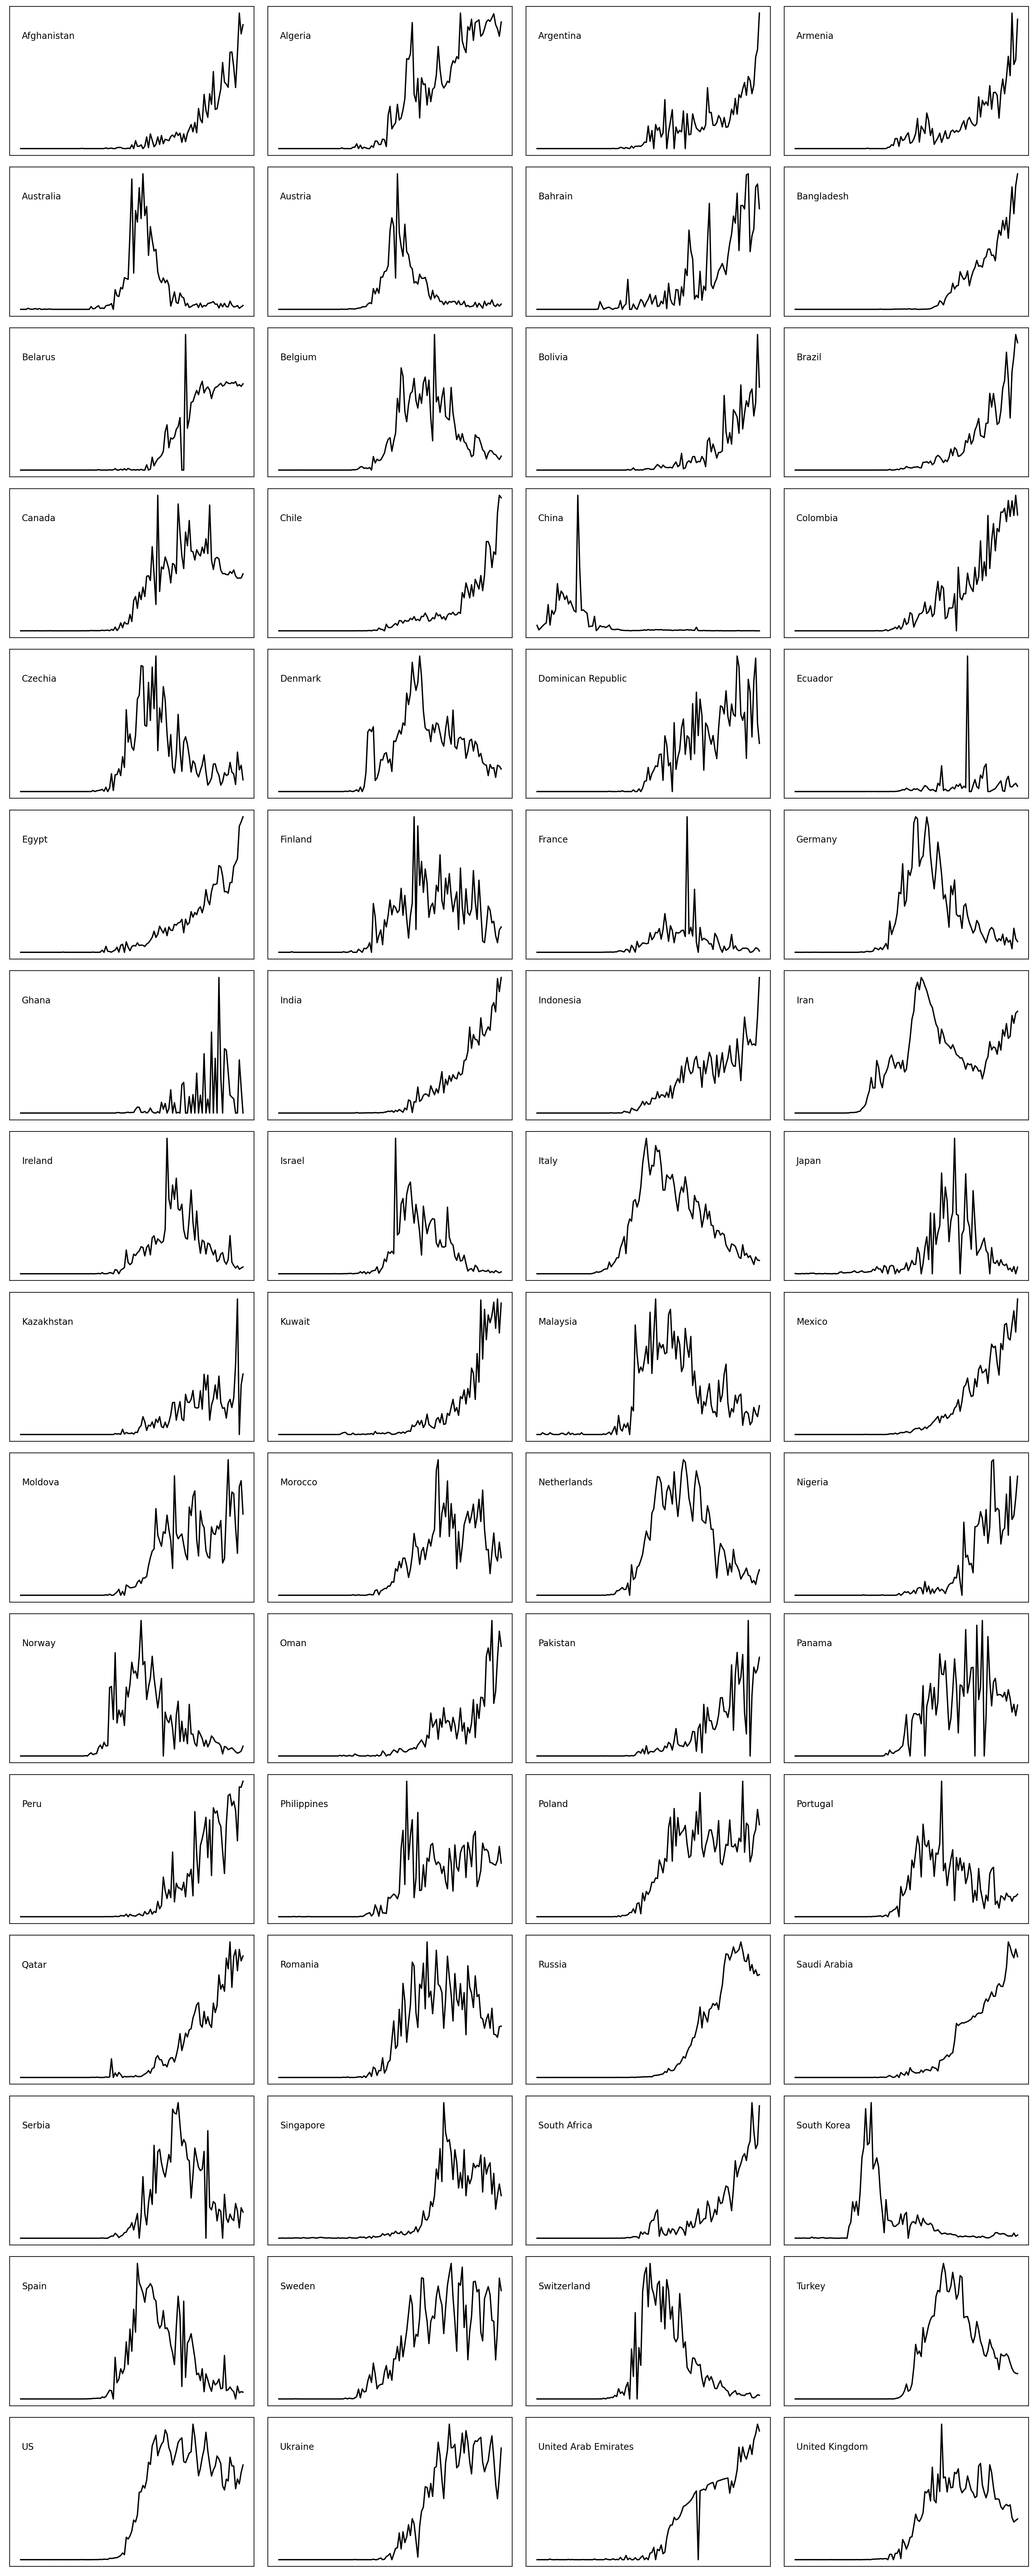

In [24]:
fig = plt.figure(figsize=(16,10), dpi=200, constrained_layout=True)

axs = fig.subplots(nrows=8, ncols=8)

for i in range(len(new_data_thousand_norm.columns)):
    # plot column
    axs.flat[i].plot(new_data_thousand_norm.index, new_data_thousand_norm.iloc[:,i], color='black')
    # remove axis labels
    axs.flat[i].get_xaxis().set_ticks([])
    axs.flat[i].get_yaxis().set_ticks([])
    # write contry notation
    axs.flat[i].annotate(new_data_thousand_norm.iloc[:,i].name, (0.05, 0.8),xycoords='axes fraction', va='center', ha='left')

Use [Scikit-bio](http://scikit-bio.org/) for [DistanceMatrix](http://scikit-bio.org/docs/latest/generated/skbio.stats.distance.html)

The Bray Curtis distance/dissimilarity or Sorensen distance is used to **quantify the differences in species populations between two different sites.**
It’s used primarily in ecology and biology, and can be calculated with the following formula:

$$ BC_{ij} = 1 - \frac{2C_{ij}}{S_{i} + S_{j}} $$

where:
 - $i$ and $j$ are the two different sites,
 - $S_{i}$ is the toal number of specimens counted on site $i$
 - $S_{j}$ is the toal number of specimens counted on site $j$,
 - $C_{ij}$ is the sum of only the lesser counts for each of the species found in both sides.

or even:

$$ BC_{ij} = \frac{ \sum_{k=1}^{n} |x_{ik} - x_{jk}|}{ \sum_{k=1}^{n} (x_{ik} + x_{jk}) } $$

where:
 - $x_{ik}$ is the $k^{th}$ specimen of site $i$,
 - $x_{ij}$ is the $k^{th}$ specimen of site $j$.
 
The result for each site is a number between 0 and 1. A value closer to 0 represent similar sites whereas a value closer to 1 means that those two sites are different.

In [198]:
def bray_curtis_distance(table, sample1_id, sample2_id):
    '''function to calculate bray-curtis distance'''
    numerator = 0
    denominator = 0
    sample1_counts = table[sample1_id]
    sample2_counts = table[sample2_id]
    for sample1_count, sample2_count in zip(sample1_counts, sample2_counts):
        numerator += abs(sample1_count - sample2_count)
        denominator += sample1_count + sample2_count
    return numerator / denominator

In [199]:
from skbio.stats.distance import DistanceMatrix
from numpy import zeros

def table_to_distances(table, pairwise_distance_fn):
    '''pairwise distance as a table'''
    sample_ids = table.columns
    num_samples = len(sample_ids)
    data = zeros((num_samples, num_samples))
    for i, sample1_id in enumerate(sample_ids):
        for j, sample2_id in enumerate(sample_ids[:i]):
            data[i,j] = data[j,i] = pairwise_distance_fn(table, sample1_id, sample2_id)
    return DistanceMatrix(data, sample_ids)

In [200]:
# Produce a bray-curtis distance matrix
bc_dm = table_to_distances(new_data_thousand_norm, bray_curtis_distance)
print(bc_dm)

83x83 distance matrix
IDs:
'Afghanistan', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria', ...
Data:
[[0.         0.31185806 0.18149104 ... 0.23887016 0.31867572 0.2885236 ]
 [0.31185806 0.         0.26442997 ... 0.13610413 0.12701846 0.26980996]
 [0.18149104 0.26442997 0.         ... 0.23841033 0.24220027 0.21069067]
 ...
 [0.23887016 0.13610413 0.23841033 ... 0.         0.16596572 0.22758581]
 [0.31867572 0.12701846 0.24220027 ... 0.16596572 0.         0.20223729]
 [0.2885236  0.26980996 0.21069067 ... 0.22758581 0.20223729 0.        ]]


[scikit-learn PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [201]:
# Using PCA on distance matrix and keep the first two components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
projected = pca.fit_transform(bc_dm.data)

In [202]:
# Variance explained by the first two components
print(pca.explained_variance_)

[0.88196282 0.59084856]


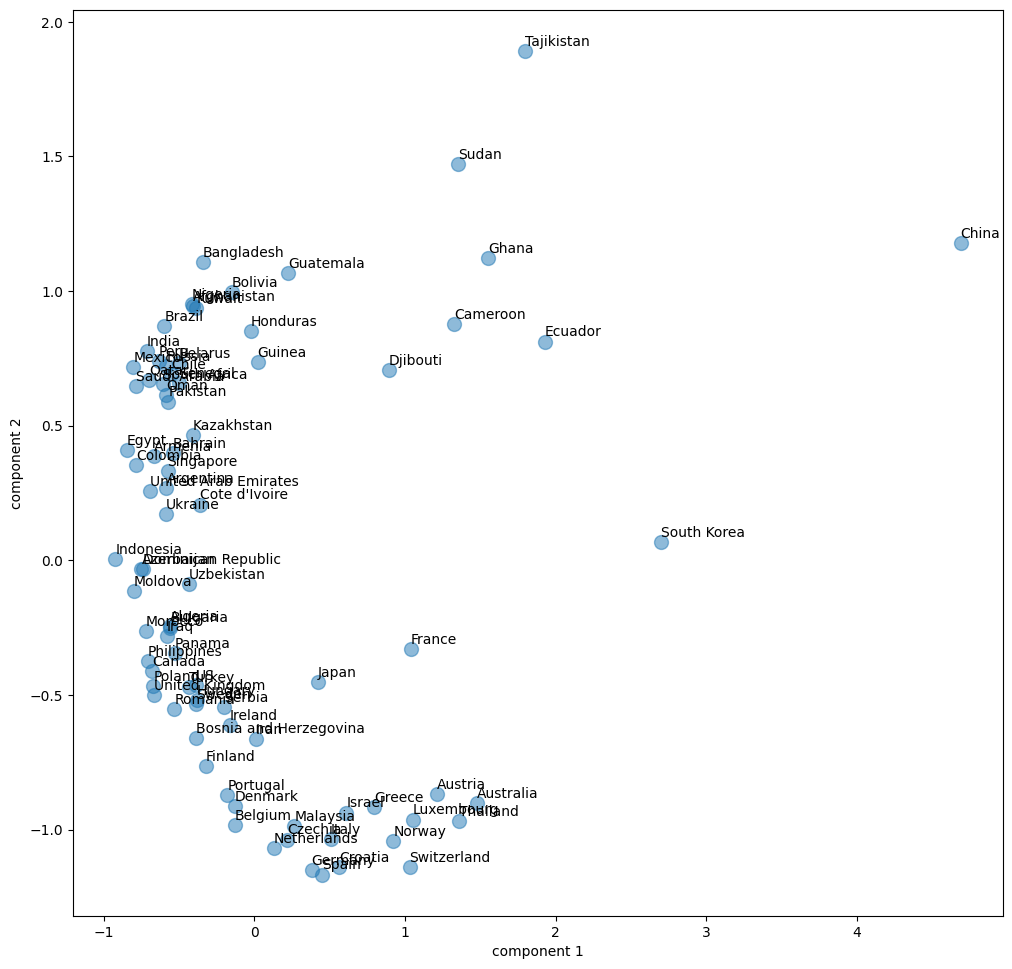

In [203]:
plt.figure(figsize=(12,12), dpi=100)

plt.scatter(projected[:, 0], projected[:, 1], s=100, alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')

for i, txt in enumerate(bc_dm.ids):
    plt.annotate(txt, (projected[:, 0][i], projected[:, 1][i]+0.02))

In [204]:
# Cluster countries using K-mean
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=4, random_state=0).fit(projected)
kmeans.labels_

array([0, 3, 0, 0, 1, 1, 3, 0, 0, 0, 3, 0, 3, 0, 3, 2, 3, 0, 2, 0, 0, 1,
       1, 3, 2, 3, 2, 0, 3, 1, 1, 2, 1, 0, 0, 0, 3, 0, 3, 3, 3, 3, 1, 1,
       1, 0, 0, 1, 1, 0, 3, 3, 1, 0, 1, 0, 0, 3, 0, 3, 3, 3, 0, 3, 0, 0,
       0, 3, 0, 0, 2, 1, 2, 3, 1, 2, 1, 3, 3, 0, 0, 3, 3], dtype=int32)

In [240]:
# Assign color to each cluster
# #d7191c - red
# #2b83ba - blue
# #fdae61 - orange
# #1a9641 - green
color = []
for i in kmeans.labels_:
    if i == 0: # phase 1
        color.append('#fdae61')
    elif i == 1: # phase 3
        color.append('#1a9641')
    elif i == 2: # past phase 3
        color.append('#2b83ba')
    elif i == 3: # phase 2
        color.append('#d7191c')

In [241]:
# Create a metadata table
cluster_data = pd.DataFrame({'Cluster':kmeans.labels_,
                            'Country':bc_dm.ids,
                            'Color':color,
                            'Confirmed':[new_data_thousand[i].sum() for i in bc_dm.ids],
                            'PC1':projected[:, 0],
                            'PC2':projected[:, 1],
                           },)
cluster_data

Cluster               Country    Color     Confirmed       PC1       PC2
0         0           Afghanistan  #fdae61    640.592283 -0.408265  0.944726
1         3               Algeria  #d7191c    706.063429 -0.560218 -0.242782
2         0             Argentina  #fdae61    757.488859 -0.584556  0.268360
3         0               Armenia  #fdae61    572.849497 -0.668066  0.386294
4         1             Australia  #1a9641    622.423164  1.475895 -0.901090
..      ...                   ...      ...           ...       ...       ...
78        3                    US  #d7191c  10208.504329 -0.386679 -0.462440
79        0               Ukraine  #fdae61   1049.183428 -0.585742  0.171441
80        0  United Arab Emirates  #fdae61   1234.544990 -0.693663  0.258406
81        3        United Kingdom  #d7191c   4100.019336 -0.665400 -0.501316
82        3            Uzbekistan  #d7191c    408.330710 -0.434114 -0.086931

[83 rows x 6 columns]

In [242]:
# Re-assign cluster id as desired order
cluster_data = cluster_data.replace({'Cluster': {0: 7, 1: 6, 2: 5, 3: 4}})
cluster_data = cluster_data.sort_values(by=['Cluster', 'Confirmed'], ascending=False)
cluster_data = cluster_data.reset_index(drop=True)
cluster_data

Cluster                 Country    Color    Confirmed       PC1       PC2
0         7                  Russia  #fdae61  3954.846903 -0.586277  0.721148
1         7                  Brazil  #fdae61  3921.722626 -0.598895  0.870945
2         7                   India  #fdae61  2451.601191 -0.714753  0.776746
3         7                    Peru  #fdae61  2314.099240 -0.635528  0.739921
4         7            Saudi Arabia  #fdae61  1854.102248 -0.784917  0.648154
..      ...                     ...      ...          ...       ...       ...
78        4                 Hungary  #d7191c   479.758891 -0.382311 -0.517944
79        4              Azerbaijan  #d7191c   474.431403 -0.750499 -0.031312
80        4              Uzbekistan  #d7191c   408.330710 -0.434114 -0.086931
81        4                Bulgaria  #d7191c   390.543249 -0.559029 -0.249961
82        4  Bosnia and Herzegovina  #d7191c   388.743544 -0.388473 -0.659941

[83 rows x 6 columns]

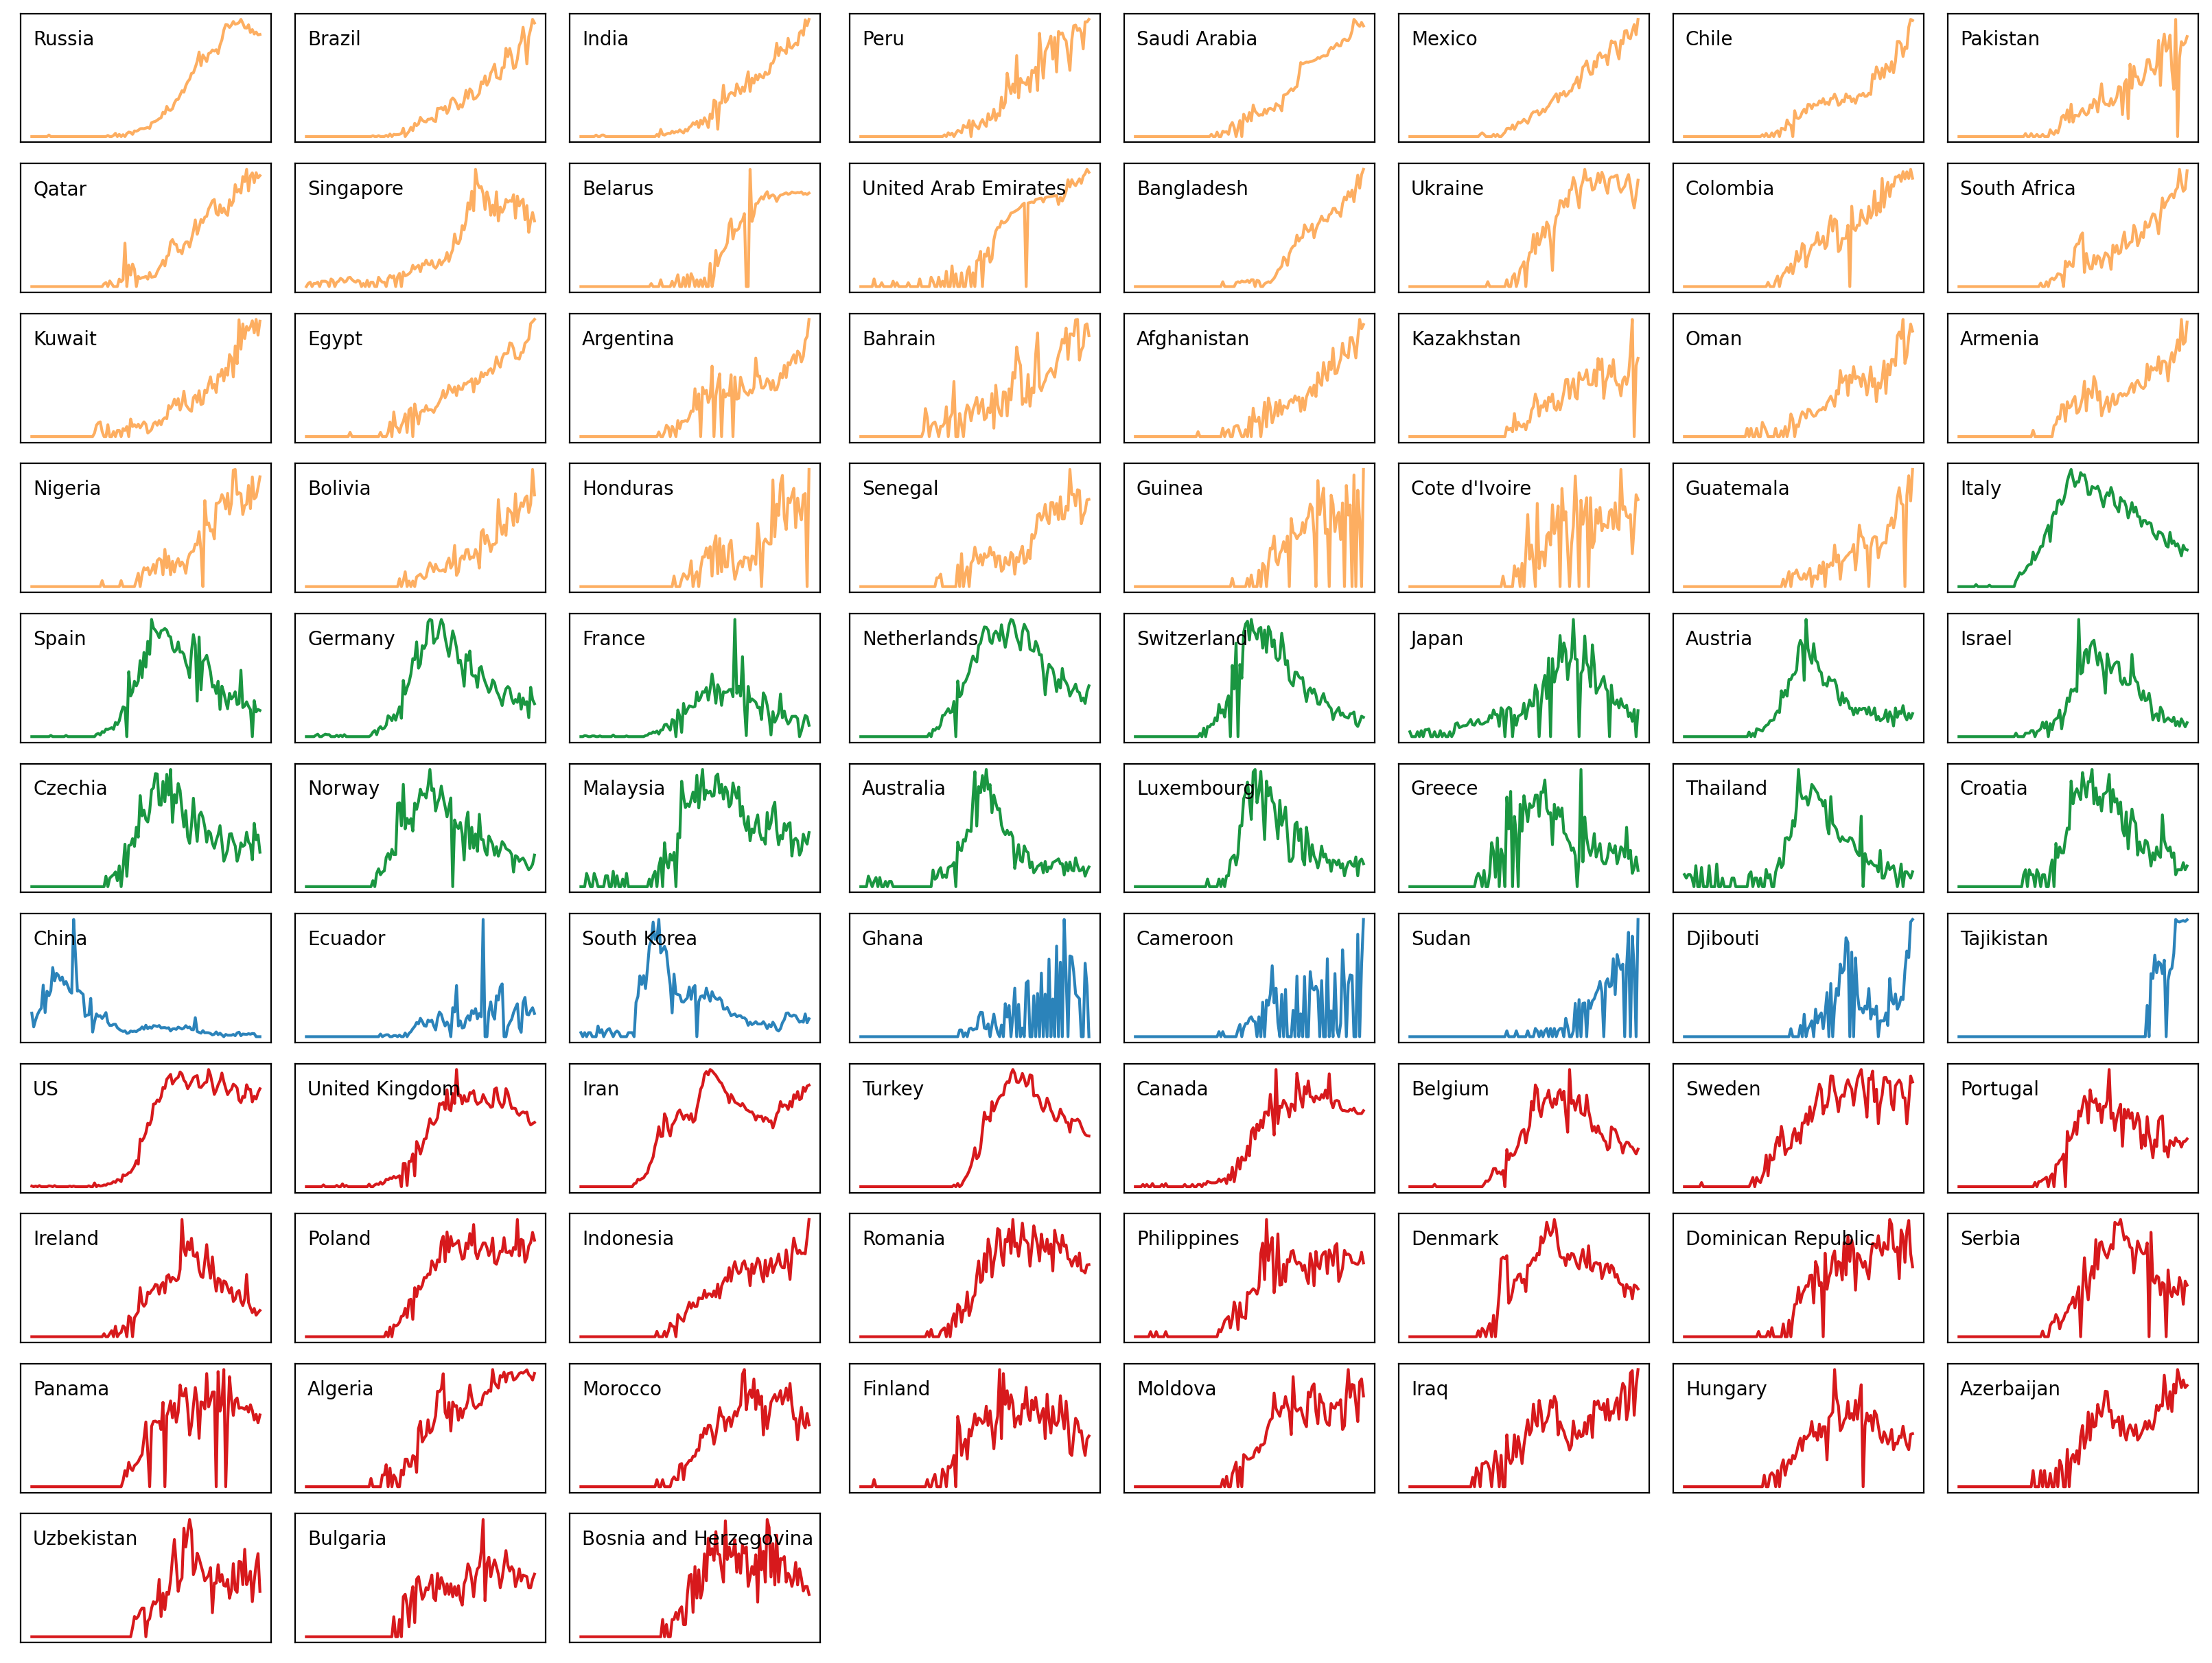

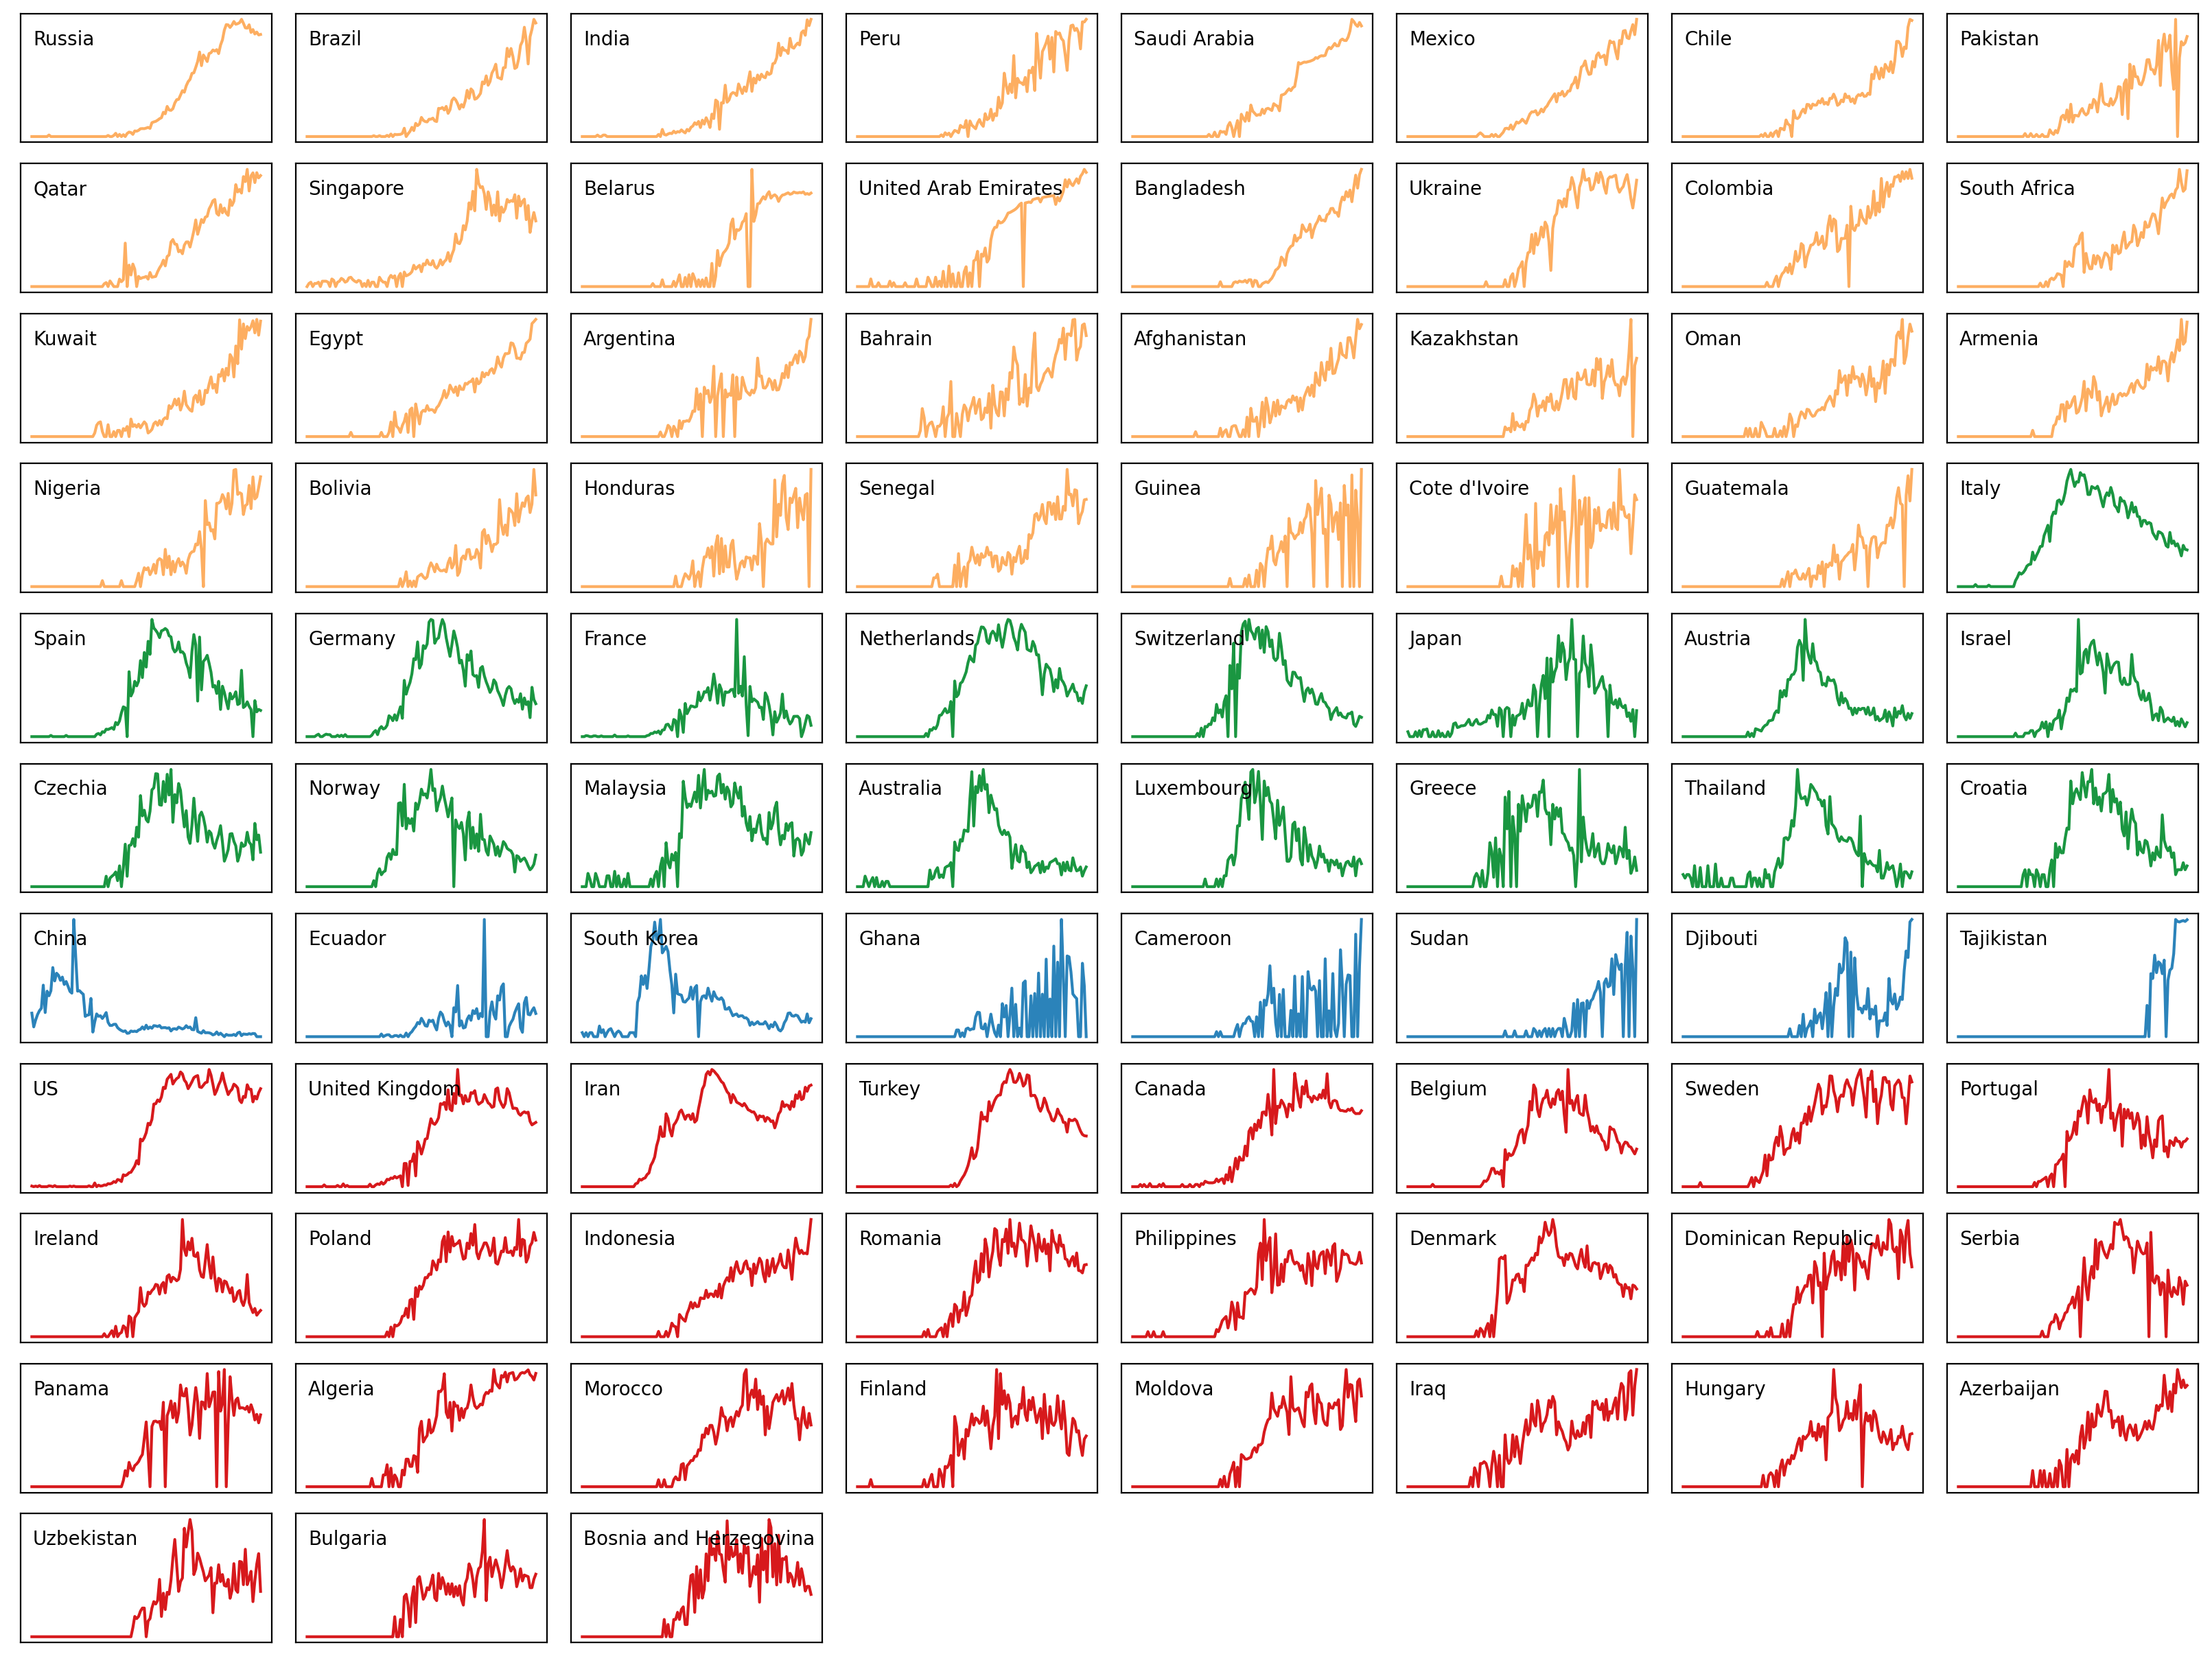

In [243]:
# make plot
fig1 = plt.figure(figsize=(16,12), dpi=200, constrained_layout=True)

axs1 = fig1.subplots(nrows=11, ncols=8)

for order, i in cluster_data.iterrows():          
    axs1.flat[order].plot(new_data_thousand_norm.index, new_data_thousand_norm[i['Country']], color=i['Color'])
    axs1.flat[order].get_xaxis().set_ticks([])
    axs1.flat[order].get_yaxis().set_ticks([])
    axs1.flat[order].annotate(i['Country'], (0.05, 0.8),xycoords='axes fraction', va='center', ha='left')

# delete unused subplots
num_plots = 11 * 8
num_used_plots = cluster_data.shape[0]
for i in range(num_used_plots, num_plots):
    axs1.flat[i].set_axis_off()

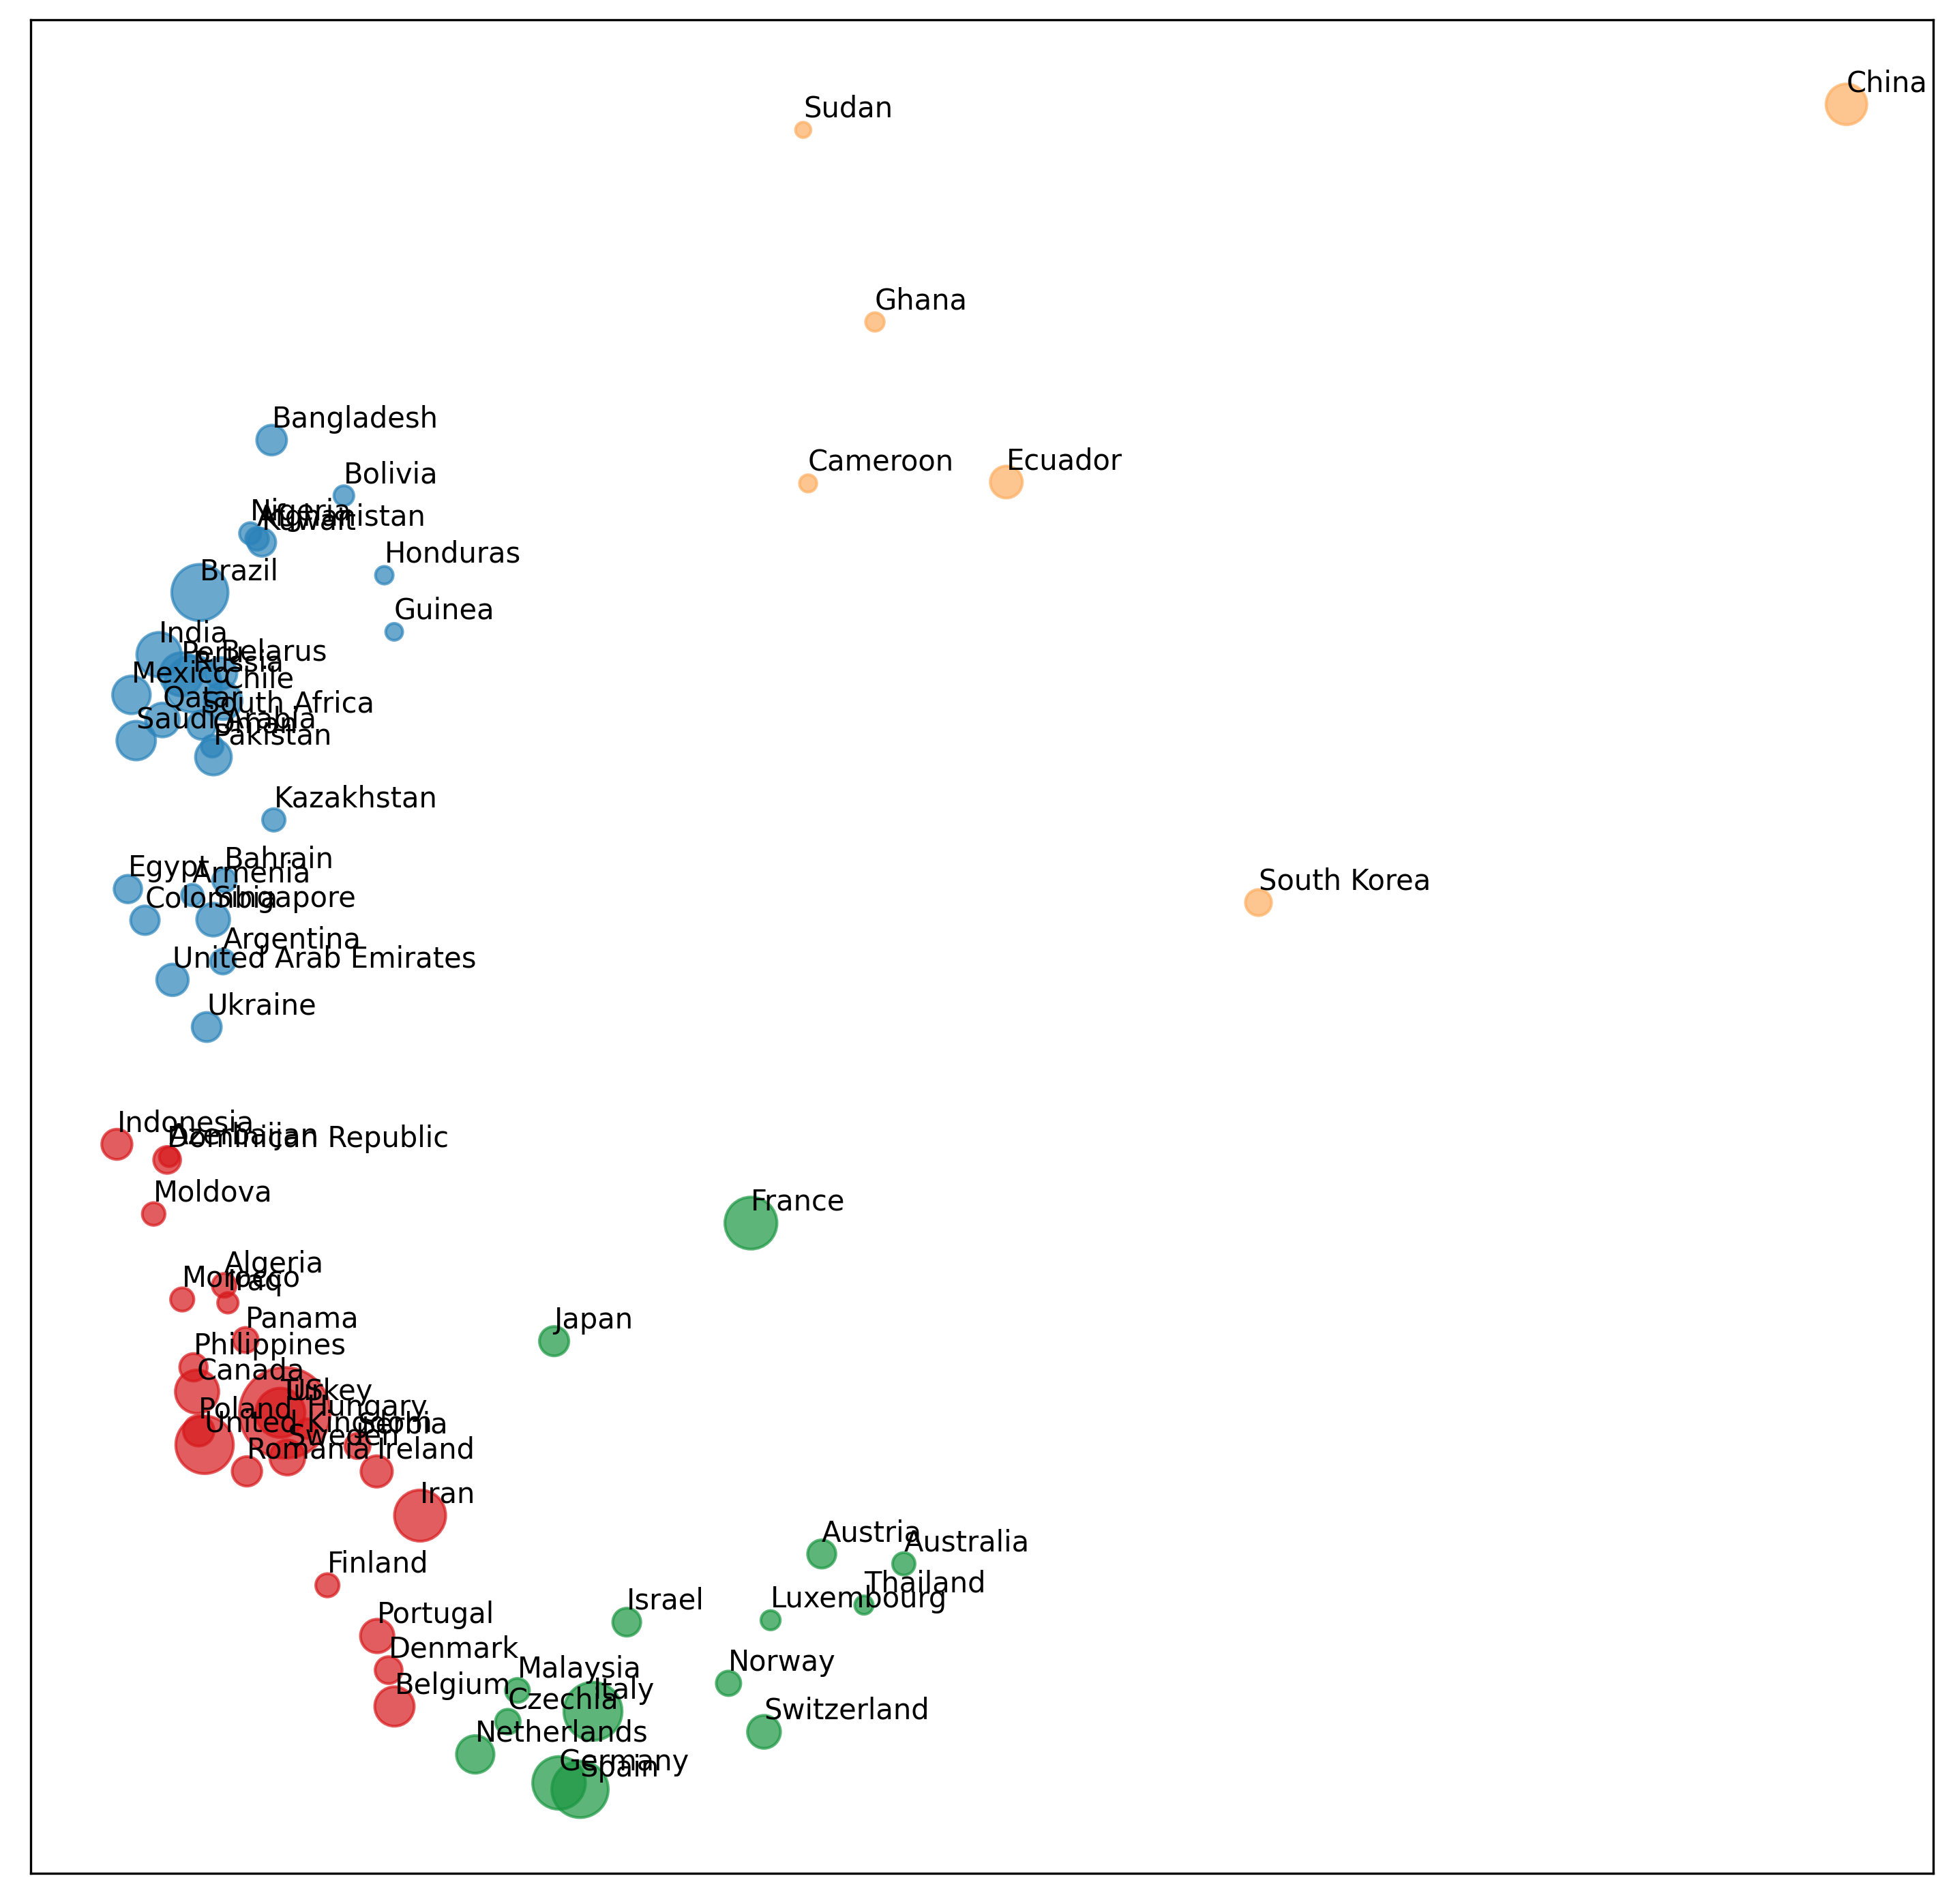

In [194]:
fig3 = plt.figure(figsize=(12,12), dpi=300)
ax1 = fig3.add_subplot()

ax1.scatter(cluster_data['PC1'], cluster_data['PC2'], c=cluster_data['Color'], s=cluster_data['Confirmed']/10, alpha=0.7)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
#ax1.set_xlabel('PC1({:.2%} variance explained)'.format(pca.explained_variance_[0]))
#ax1.set_ylabel('PC2({:.2%} variance explained)'.format(pca.explained_variance_[1]))

for i, txt in enumerate(cluster_data['Country']):
    ax1.annotate(txt, (cluster_data['PC1'][i], cluster_data['PC2'][i]+0.02))

## Saving Data

In [38]:
# create cluster column
#output_cluster_data = cluster_data.sort_values(by=['Country'])
#output_cluster_data = output_cluster_data.reset_index(drop=True)
# insert new column in
#classified_dataframe.insert(0, "Cluster", output_cluster_data['Cluster'].to_list(), allow_duplicates=True)
#classified_dataframe

In [39]:
saved_cluster_data = cluster_data.drop(labels=['Color', 'PC1', 'PC2', 'Confirmed'], axis=1)
saved_cluster_data.set_index(keys=['Country'])

Cluster
Country                
US                    9
United Kingdom        9
Turkey                9
Iran                  9
Canada                9
...                 ...
Kazakhstan            5
Nigeria               5
Oman                  5
Armenia               5
Bolivia               5

[64 rows x 1 columns]

In [40]:
# save classified countries
saved_cluster_data.set_index(keys=['Country']).to_csv(f'{DATA_FOLDER}/world-class-data.csv')

In [41]:
# save countries and dates
new_data_thousand.transpose().to_csv(f'{DATA_FOLDER}/world-data-simple.csv')

## Part 3 - Supervised Learning

In [42]:
test = new_data_thousand_norm.transpose()
test

0    1         2    3         4         5    6    \
Country/Region                                                                
Afghanistan           0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0   
Algeria               0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0   
Argentina             0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0   
Armenia               0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0   
Australia             0.000000  0.0  0.000000  0.0  0.008048  0.002012  0.0   
...                        ...  ...       ...  ...       ...       ...  ...   
Turkey                0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0   
US                    0.000028  0.0  0.000028  0.0  0.000083  0.000000  0.0   
Ukraine               0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0   
United Arab Emirates  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0   
United Kingdom        0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0   

                           7         8         9    ...       111       112  \
Country/Region                                      ...                       
Afghanistan           0.000000  0.000000  0.000000  ...  0.475043  0.452668   
Algeria               0.000000  0.000000  0.000000  ...  0.884422  0.934673   
Argentina             0.000000  0.000000  0.000000  ...  0.439815  0.487654   
Armenia               0.000000  0.000000  0.000000  ...  0.415954  0.512821   
Australia             0.002012  0.006036  0.000000  ...  0.020121  0.018109   
...                        ...       ...       ...  ...       ...       ...   
Turkey                0.000000  0.000000  0.000000  ...  0.331647  0.318996   
US                    0.000000  0.000000  0.000055  ...  0.593981  0.581132   
Ukraine               0.000000  0.000000  0.000000  ...  0.648789  0.695502   
United Arab Emirates  0.004251  0.000000  0.000000  ...  0.832094  0.770457   
United Kingdom        0.000000  0.000000  0.000229  ...  0.390358  0.371465   

                           113       114       115       116       117  \
Country/Region                                                           
Afghanistan           0.710843  0.712565  0.600688  0.450947  0.702238   
Algeria               0.949749  0.939698  0.964824  0.994975  0.914573   
Argentina             0.393519  0.532407  0.503086  0.405864  0.467593   
Armenia               0.404558  0.524217  0.680912  0.538462  1.000000   
Australia             0.060362  0.032193  0.018109  0.020121  0.028169   
...                        ...       ...       ...       ...       ...   
Turkey                0.318217  0.332425  0.313351  0.266251  0.225380   
US                    0.756273  0.692218  0.690726  0.523295  0.595529   
Ukraine               0.730104  0.835640  0.913495  0.749135  0.562284   
United Arab Emirates  0.741764  0.793836  0.845909  0.776833  0.884166   
United Kingdom        0.395626  0.408107  0.395855  0.404672  0.310775   

                           118       119       120  
Country/Region                                      
Afghanistan           1.000000  0.846816  0.913941  
Algeria               0.884422  0.829146  0.934673  
Argentina             0.675926  0.731481  1.000000  
Armenia               0.621083  0.655271  0.954416  
Australia             0.008048  0.018109  0.028169  
...                        ...       ...       ...  
Turkey                0.198910  0.189179  0.187038  
US                    0.559854  0.643445  0.698961  
Ukraine               0.449827  0.612457  0.823529  
United Arab Emirates  0.927736  1.000000  0.950053  
United Kingdom        0.278140  0.289477  0.300813  

[64 rows x 121 columns]

In [43]:
saved_cluster_data

Cluster         Country
0         9              US
1         9  United Kingdom
2         9          Turkey
3         9            Iran
4         9          Canada
..      ...             ...
59        5      Kazakhstan
60        5         Nigeria
61        5            Oman
62        5         Armenia
63        5         Bolivia

[64 rows x 2 columns]

In [44]:
# replace country/region index for cluster id
labeled_data = test.join(saved_cluster_data.set_index('Country')).set_index('Cluster')
labeled_data

0    1         2    3         4         5    6         7    \
Cluster                                                                    
5        0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
9        0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
5        0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
5        0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
8        0.000000  0.0  0.000000  0.0  0.008048  0.002012  0.0  0.002012   
...           ...  ...       ...  ...       ...       ...  ...       ...   
9        0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
9        0.000028  0.0  0.000028  0.0  0.000083  0.000000  0.0  0.000000   
9        0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
5        0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.004251   
9        0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000   

              8         9    ...       111       112       113       114  \
Cluster                      ...                                           
5        0.000000  0.000000  ...  0.475043  0.452668  0.710843  0.712565   
9        0.000000  0.000000  ...  0.884422  0.934673  0.949749  0.939698   
5        0.000000  0.000000  ...  0.439815  0.487654  0.393519  0.532407   
5        0.000000  0.000000  ...  0.415954  0.512821  0.404558  0.524217   
8        0.006036  0.000000  ...  0.020121  0.018109  0.060362  0.032193   
...           ...       ...  ...       ...       ...       ...       ...   
9        0.000000  0.000000  ...  0.331647  0.318996  0.318217  0.332425   
9        0.000000  0.000055  ...  0.593981  0.581132  0.756273  0.692218   
9        0.000000  0.000000  ...  0.648789  0.695502  0.730104  0.835640   
5        0.000000  0.000000  ...  0.832094  0.770457  0.741764  0.793836   
9        0.000000  0.000229  ...  0.390358  0.371465  0.395626  0.408107   

              115       116       117       118       119       120  
Cluster                                                              
5        0.600688  0.450947  0.702238  1.000000  0.846816  0.913941  
9        0.964824  0.994975  0.914573  0.884422  0.829146  0.934673  
5        0.503086  0.405864  0.467593  0.675926  0.731481  1.000000  
5        0.680912  0.538462  1.000000  0.621083  0.655271  0.954416  
8        0.018109  0.020121  0.028169  0.008048  0.018109  0.028169  
...           ...       ...       ...       ...       ...       ...  
9        0.313351  0.266251  0.225380  0.198910  0.189179  0.187038  
9        0.690726  0.523295  0.595529  0.559854  0.643445  0.698961  
9        0.913495  0.749135  0.562284  0.449827  0.612457  0.823529  
5        0.845909  0.776833  0.884166  0.927736  1.000000  0.950053  
9        0.395855  0.404672  0.310775  0.278140  0.289477  0.300813  

[64 rows x 121 columns]

In [45]:
# extract the data to arrays
all_inputs = labeled_data.values
all_labels = labeled_data.index.to_list()

In [46]:
from sklearn.model_selection import train_test_split

(training_inputs, testing_inputs,
 training_classes, testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

In [47]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs, testing_classes)

0.8125

''

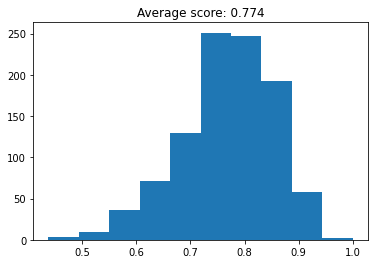

In [48]:
import numpy as np

model_accuracies = []

for repetition in range(1000):
    (training_inputs, testing_inputs,
     training_classes, testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)
plt.title('Average score: {}'.format(np.mean(model_accuracies)))
;

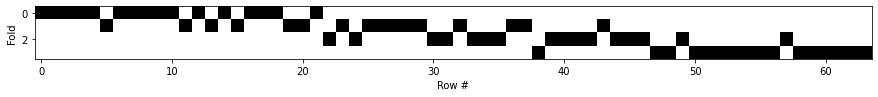

In [49]:
from sklearn.model_selection import StratifiedKFold

def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(n_splits=4), all_inputs, all_labels)

''

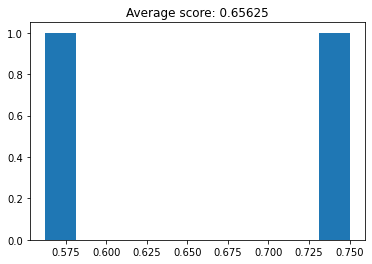

In [50]:
from sklearn.model_selection import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=StratifiedKFold(n_splits=2))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

In [51]:
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {
    'max_depth': [1, 2, 3, 4, 5],
    'max_features': [1, 2, 3, 4]
}

cross_validation = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8125
Best parameters: {'max_depth': 5, 'max_features': 2}


''

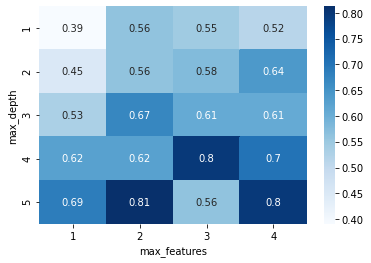

In [52]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (5, 4)
sb.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')
;

In [53]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {
    'n_estimators': [10, 25, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_features': [1, 2, 3, 4]
}

cross_validation = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.953125
Best parameters: {'criterion': 'entropy', 'max_features': 4, 'n_estimators': 25}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

''

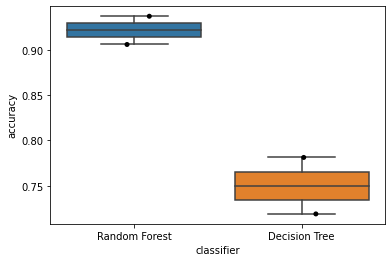

In [54]:
random_forest_classifier = grid_search.best_estimator_

random_forest_dataframe = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, all_inputs, all_labels, cv=2),
                       'classifier': ['Random Forest'] * 2})
decision_tree_dataframe = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=2),
                      'classifier': ['Decision Tree'] * 2})
both_df = random_forest_dataframe.append(decision_tree_dataframe)

sb.boxplot(x='classifier', y='accuracy', data=both_df)
sb.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')
;

# References

 - https://thespinoff.co.nz/society/09-03-2020/the-three-phases-of-covid-19-and-how-we-can-make-it-manageable/
 - https://www.cdc.gov/flu/pandemic-resources/planning-preparedness/global-planning-508.html